In [165]:
# Standard library imports
import math
import os
import re
import shutil
import sys
import unicodedata
import warnings
from itertools import product
from datetime import datetime

# Third-party library imports
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Helper functions

### Security

In [166]:
# DECORATOR FOR INPUT SANITIZATION
# Safety Mesaures for verfying potential harmful user inputs

def remove_accents(input_str):
    """Replace accents from a string with equivalent letter, issuing a warning if changes are made."""
    original_str = input_str  # Store the original string for comparison
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    result = "".join(c for c in nfkd_form if not unicodedata.combining(c))

    if result != original_str:  # Check if any changes were made
        warnings.warn(f"Accents were removed from input. ('{original_str}' -> '{result}')", UserWarning)

    return result

def sanitize_filename(input_str):
    """Sanitizes a filename by removing accents and disallowed characters."""
    input_str = remove_accents(input_str)  # Remove accents first
    result = input_str

    # Checks for prohibited characters (then deletes them)
    # allowed_chars = r"^[a-zA-Z0-9_\-\.]+$"
    allowed_chars = r"^[a-zA-Z0-9_\-\./]+$" # Allow '/' in user input
    if input_str and not re.fullmatch(allowed_chars, input_str):
        result = re.sub(allowed_chars, "", input_str)  # Sanitize (remove invalid chars)
        warnings.warn(f"This argument is unsafe. A sanitized version will be used instead. ('{input_str}' -> '{result}')", UserWarning)

    #if input_str == result:
    #    print("Original name: '", input_str)
    #    print("Sanitized name: '", result)
    #    print()

    return result

# Decorator wrapper
def validate_filenames():
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Arguments Sanitization 
            sanitized_args = []
            for arg in args:
                if isinstance(arg, str):
                    original_arg = arg
                    sanitized_arg = sanitize_filename(arg) # Sanitize argument
                    if sanitized_arg != original_arg:
                        warnings.warn(f"Argument '{original_arg}' sanitized to '{sanitized_arg}'.", UserWarning)
                else:
                    sanitized_arg = arg
                    # warnings.warn(f"Argument '{arg}' is not string dtype. Be sure the current function can handle it.", UserWarning)
                sanitized_args.append(sanitized_arg)

            # Keyword Arguments Sanitization 
            sanitized_kwargs = {}
            for key, value in kwargs.items():
                if isinstance(value, str):
                    original_value = value
                    sanitized_value = sanitize_filename(value) # Sanitize value for keyword
                    if sanitized_value != original_value:
                        warnings.warn(f"Keyword argument '{key}'='{original_value}' sanitized to '{sanitized_value}'.", UserWarning)
                else:
                    sanitized_value = value
                    # warnings.warn(f"Argument '{value}' is not string dtype. Be sure the current function can handle it.", UserWarning)
                sanitized_kwargs[key] = sanitized_value

            # Return sanitized arguments
            return func(*sanitized_args, **sanitized_kwargs)
        return wrapper
    return decorator


In [167]:
def timestamp(message=''):
    currenttime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    if message:
        print(message, currenttime, sep=": ")
    else:
        print('Timestamp', currenttime, sep=": ")

### File management

In [168]:
@validate_filenames()
def create_dir(folder_path):
    # 1) Verifica si el directorio existe y confirma si es necesario vaciarlo
    if os.path.exists(folder_path):
        print(f"🚨 ALERTA: El directorio en el que quieres guardar ya tiene contenido, para proceder deberás eliminarlo.")
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el directorio '{folder_path}' y su contenido? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            shutil.rmtree(folder_path)  # Elimina el directorio y todo su contenido
            print("> Directorio eliminado:\n",folder_path)
        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()
    else:
        print("🆕 El directorio no existe, se creará uno nuevo:",{folder_path})
        
    # 2) Crea el directorio especificado
    os.makedirs(folder_path, exist_ok=True)
    print("✅ El directorio ya está disponible:\n",{folder_path})

In [169]:
@validate_filenames()
def empty_dir(folder_path):
    """
    Elimina todo el contenido (archivos y subdirectorios) de una carpeta especificada.

    Args:
        folder_path: La ruta de la carpeta que se va a limpiar.

    Raises:
        FileNotFoundError: Si la carpeta especificada no existe.
        OSError: Si ocurre un error durante la eliminación de archivos o directorios.
    """

    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"❗️La carpeta '{folder_path}' no existe.")

    try:
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el contenido de '{folder_path}'? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            for file in os.listdir(folder_path):  # Itera sobre los archivos y directorios
                file_path = os.path.join(folder_path, file)  # Crea la ruta completa

                if os.path.isfile(file_path):  # Si es un archivo
                    os.remove(file_path)  # Elimina el archivo
                    #print(f"Archivo eliminado: {file_path}")

                elif os.path.isdir(file_path):  # Si es un directorio
                    shutil.rmtree(file_path)  # Elimina el directorio y su contenido de forma recursiva
                    #print(f"Directorio eliminado: {file_path}")

            print("✔️ Contenido de la carpeta eliminado:\n", folder_path)

        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()

    except OSError as e:
        raise OSError(f"🚫 Error al limpiar la carpeta:\n {e}")    
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")

In [170]:
# VERSIÓN MODIFICADA (in/out invertido respecto a TilesSplitter script)
@validate_filenames()
def build_filename(dset: str = '', dtype: str = '', dir: str='in', name: str | None = None, prefix: str = '', verbose: bool = False) -> str:
    """ 
    Construye el nombre y ruta necesaria para cargar/guardar cada archivo del dataset.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - dtype (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.
        - prefix (str): Establece un prefijo para el nombre del archivo (ej:'tile00x00.').
        - verbose (bool): Ofrece información verbal al usuario.

    Retorna:
        - str: Por defecto entrega la ruta de la carpeta (del dataset de entrada o salida).
        - Si además se incluye 'dset' o 'dtype', entrega el directorio de la subcarpeta correspondiente.
        - Si se incluye un nombre de archivo, devuelve la ruta con el formato adecuado.
    """
    
    # Function Example:
    #    - in: "/data/raw/3.5m.v3i.yolov8/valid/labels/
    #            209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - out: "/data/processed/3.5m.v3i.yolov8/valid/labels/
    #            tile00x00.209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - shape: /data/{dir}/{PATH}{dsuffix}/{dset}/{dtype}/ <- Folder path
    #             {prefix}.{filename}.{dtype}        <- Full filename

    # INITIALIZER LOGIC
    # Verifies that every input has the correct type
    assert (isinstance(name, str | None)
            and isinstance(dset, str)
            and isinstance(dtype, str)
            and isinstance(prefix, str)
            and isinstance(dir, str)), "❕All arguments must be strings."

    try:
        PATH
    except NameError:
        raise NameError("❗️ PATH constant is not defined.")
    try:
        OUTPUT_SUFFIX
    except NameError:
        raise NameError("❗️ OUTPUT_SUFFIX constant is not defined.")
    try:
        POINTER
    except NameError:
        raise NameError("❗️ POINTER constant is not defined.")
    
    # Normalize inputs
    dset = dset.lower()
    dtype = dtype.lower()
    dir = dir.lower()

    # This help splitting the name in half
    # for inserting the prefix next to photo filename (ej: 209_205_50_JPG)
    #POINTER = '.rf.' # could be modified for differente tag name formats
    pointer_idx = name.find(POINTER) if name != None else ""

    # Default folders and extensions
    dset_map = {
        'train': 'train/',
        'valid': 'valid/',
        'test': 'test/'
    }
    # Handle both plural and singular inputs
    dtype_map = {
        'image': ('images', 'jpg'),
        'images': ('images', 'jpg'),
        'label': ('labels', 'txt'),
        'labels': ('labels', 'txt')
    }

    def get_dset_path(dset_val: str) -> str:
        if dset_val not in dset_map:
            raise ValueError("❕Invalid 'dset': must be 'train', 'valid', or 'test'.  Or leave it empty if not needed (default option).")
        return dset_map[dset_val]

    def get_dtype_info(dtype_val: str) -> tuple[str, str]:
        if dtype_val not in dtype_map:
            raise ValueError("❕Invalid 'type': must be 'image' or 'label'. Or leave it empty if not needed (default option).")
        return dtype_map[dtype_val]
    
    # FILENAME CREATION LOGIC
    # Output dataset logic
    if dir == 'in':
        root = PATH
        base_path = f"{root}{get_dset_path(dset)}" if dset else root
        
        if dtype:
            type_folder, extension = get_dtype_info(dtype)
            base_path = f"{base_path}{type_folder}/"
        else:
            type_folder, extension = "",""

        print("✔️ Dataset root created successfully") if verbose else ""
        #return f"{base_path}{filename}" # Ending for 'out' option
    
    # Input dataset logic
    elif dir == 'out':
        root = PATH.replace('processed','raw')
        if OUTPUT_SUFFIX:
            root = f"{root[:-1]}{OUTPUT_SUFFIX}/"

        base_path = f"{root}{get_dset_path(dset)}{get_dtype_info(dtype)[0]}/"
        _, extension = get_dtype_info(dtype)
        
    else:
        raise ValueError("❕Invalid 'dir': must be 'in' (default) or 'out'.")
    
    # PREFIX LOGIC
    # Managing filename prefixes
    if name is None or name == '':
        filename = ''
        print("🚨 WARNING: Prefix will be ignored unless a filename is provided.") if prefix else ''
    else:
        if not prefix:
            # If no prefix is defined, it keeps the original name
            filename = f"{name}.{extension}"
        else:
            if pointer_idx == -1:
                # When the reference in name format is not found, it adds the prefix at the end
                filename = f"{name}.{prefix}.{extension}"
                print(f"⚠ The oiriginal file does not follow the expected format. Filenames should inlcude a '{POINTER}' reference inside.\nTherefore, the indicated prefix value '{prefix}' will be added at the end of the current filename.") if verbose else ''
            else:
                # If the format is ok, it inserts the prefix in between the original JPG filename and the hash part
                name_jpg = name[:pointer_idx]
                name_hash = name[pointer_idx:]
                filename = f"{name_jpg}.{prefix}{name_hash}.{extension}"
    
    #print("Input:", PATH, "Output:", root)
    print("✔️ Filename created succesfully") if verbose else ""
    return f"{base_path}{filename}"

In [171]:
@validate_filenames()
def save_labels(dest_labels_file: str, export: pd.DataFrame, verbose: bool = True) -> bool:
    """
    Saves a DataFrame to a file, with each row as a space-separated string.

    Args:
        dest_labels_file: Path to the output file.
        export: DataFrame to save.

    Returns:
        True if the file was saved successfully, False otherwise.
    """
    try:
        lines = label_to_str(export)
        with open(dest_labels_file, 'w') as file:
            file.writelines(line + "\n" for line in lines)
        if verbose:
            print("El archivo de etiquetas se ha creado correctamente. Se han guardado todos los datos.")
        return True
    
    except OSError as e:
        raise OSError(f"🚫 Error al copiar la carpeta:\n {e}")
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")


### Formatting

In [172]:
def label_to_str(export: pd.DataFrame) -> list[str]:
    
    """
    Converts each row of a dataframe into string format

    Parameters:
    - Dataframe with labels (np.dataframe)

    Returns:
    - List with labels in text (list[str])
    """
    
    lines = []
    for _, row in export.iterrows():
        row_list = list(row)
        row_list[0] = int(row_list[0])
        line = ' '.join(map(str, row_list))
        lines.append(line)
        
    # Verificar que la cantidad de lineas coincide con la cantidad de labels
    if not len(lines) == len(export):
        raise ValueError("🚨 CUIDADO: el número de etiquetas en el archivo de salida y el dataframe no coinciden.")

    return lines

In [173]:
def get_index(row:int , column:int ) -> int:
    """
    Calcula el índice lineal en una estructura de datos de los mosaicos definidos en el setup inicial.

    Parámetros:
    - row: Número de fila (entero).
    - column: Número de columna (entero).

    Salida:
    - Índice lineal calculado. 
    """
    if not isinstance(COLUMNS, int):
        raise TypeError(f"❕La constante columna no está definida adecuadamente. (value:{COLUMNS})")
    if not isinstance(row, int) or not isinstance(column, int):
        raise TypeError("❕Debe introducir valores enteros para fila y columna.")
    if row < 0 or column < 0:
        raise ValueError("❕Fila y columna deben ser valores no negativos.")

    return column + (row * COLUMNS)

In [174]:
def to_origin(labels: pd.DataFrame, coord: list):
    """
    Lleva las coordenadas a la ordenada para que la gráfica sea comparativa
    """
    labels = labels.copy()
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord * 2
    return labels

In [175]:
def label_transform(df_labels: pd.DataFrame, mode: str, im_height: int, im_width: int, round: bool = True) -> pd.DataFrame:
    """
    Transforms bounding box coordinates based on the specified mode.

    Args:
        df_labels: DataFrame containing bounding box coordinates (x, y, width, height).
        mode: Transformation mode ('absolute' or 'relative').
        im_height: Image height in pixels.
        im_width: Image width in pixels.
        round: Enable/Disable output rounding (default True).

    Returns:
        Transformed DataFrame with bounding box coordinates.

    Raises:
        AssertionError: If im_width or im_height is not an integer.
        ValueError: If mode is not 'absolute' or 'relative'.
    """

    assert isinstance(im_width, int), "Dimensions should be int numbers."
    assert isinstance(im_height, int), "Dimensions should be int numbers."
    assert isinstance(mode, str), "Mode should be a string"    
    assert isinstance(df_labels, pd.DataFrame), "df_labels must be a pandas DataFrame"

    if im_height == 0 or im_width == 0:
        raise ValueError("❕Debe introducir las dimensiones de la imagen (no pueden ser 0).")
    if mode == 'absolute':
        df_labels_abs = df_labels * [1, im_width, im_height, im_width, im_height]
        if round:
            df_labels_abs = df_labels_abs.round(0).astype(int)
        df_labels_abs['class_id'] = df_labels_abs['class_id'].astype(int)
        return df_labels_abs
    elif mode == 'relative':
        df_labels_rel = df_labels / [1, im_width, im_height, im_width, im_height]
        df_labels_rel['class_id'] = df_labels_rel['class_id'].astype(int)
        return df_labels_rel
    else:
        raise ValueError("❕Debe indicar el modo de transformación deseado ('absolute' o 'relative')")
    

In [176]:
def lbl_to_bb(df_input: pd.DataFrame) -> pd.DataFrame:

    """
    Transforma un DataFrame de 'Etiquetas' a 'Bounding Boxes'.
    
    Args:
        df_input: Dataframe de coordenadas de Labels (x, y, width, height).
        
    Returns:
        df_output: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
    """
    
    # Extraer los valores como arrays NumPy (evita el overhead de Pandas)
    class_id = df_input['class_id'].values
    x_center, y_center = df_input[['x_center', 'y_center']].to_numpy().T
    width, height = df_input[['width', 'height']].to_numpy().T

    # Calcular coordenadas de bounding box de manera vectorizada
    x0 = x_center - width / 2
    x1 = x_center + width / 2
    y0 = y_center - height / 2
    y1 = y_center + height / 2


    # Crear el DataFrame con los resultados optimizados
    return pd.DataFrame({'class_id': class_id, 'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1}).astype(int)


def bb_to_lbl(df_input: pd.DataFrame) -> pd.DataFrame:
    
    """
    Transforma un DataFrame de 'Bounding Boxes' a 'Etiquetas'.
    
    Args:
        df_input: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
        
    Returns:
        df_output:  Dataframe de coordenadas de Labels (x, y, width, height).

    """

    # Extraer los valores de las coordenadas de los Bounding Boxes como arrays NumPy
    class_id = df_input['class_id'].values
    x0, x1 = df_input['x0'].values, df_input['x1'].values
    y0, y1 = df_input['y0'].values, df_input['y1'].values

    # Calcular las coordenadas del centro usando NumPy
    x_center = np.ceil((x0 + x1) / 2)
    y_center = np.ceil((y0 + y1) / 2)

    # Calcular el ancho (width) y la altura (height) usando NumPy
    width = x1 - x0
    height = y1 - y0

    # Crear el DataFrame con los resultados optimizados usando NumPy
    return pd.DataFrame({
        'class_id': class_id, 
        'x_center': x_center, 
        'y_center': y_center, 
        'width': width, 
        'height': height
    }).astype(int)

### Visualization tools

In [177]:
def draw_points(image: np.ndarray, df_labels: pd.DataFrame):
    """
    Dibuja en la imagen los centroides de cada Bounding Box.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - df_labels: pd.DataFrame -> DataFrame con columnas ['class_id','x_center', 'y_center', 'width', 'height'].
    """
    
    im_points = image.copy()
    
    # Dibujar puntos
    for _, row in df_labels.iterrows():
        x = row['x_center']
        y = row['y_center']
        point = [x, y]
        
        # Dibujar los círculos
        cv.circle(im_points, center=point, radius=7, color=(255, 0, 0), thickness=-1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [178]:
def draw_bb(image: np.ndarray, labels: pd.DataFrame, coord: tuple | list | str=(0, 0, 240, 240)):
    """
    Dibuja bounding boxes en una imagen basándose en las etiquetas proporcionadas.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - labels: pd.DataFrame -> DataFrame con columnas ['x0', 'y0', 'x1', 'y1', 'class_id'].
    - coord: tuple | list | str -> Coordenadas del tile en formato (x0, y0, x1, y1).    
    """
    im_points = image.copy()

    # Convertir `coord` a una lista de enteros si es necesario
    if isinstance(coord, str):
        coord = [int(x) for x in coord.split()]
    elif isinstance(coord, tuple):
        coord = list(coord)
    elif not isinstance(coord, list):
        raise ValueError("❗️La variable de coordenadas  debe ser una lista, tupla o string con coordenadas.")

    # Verificar que `coord` tenga 4 valores
    if len(coord) != 4:
        raise ValueError("❗️La variable de coordenadas debe contener exactamente 4 valores (x0, y0, x1, y1).")

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    #labels['x0', 'y0', 'x1', 'y1'] = to_origin(labels[['x0', 'y0', 'x1', 'y1']], coord[:2])
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord[:2] * 2
    
    # Generar colores únicos para cada class_id
    unique_classes = labels['class_id'].unique()  # Obtener clases únicas
    color_map = {cls: tuple(np.random.randint(0, 255, 3).tolist()) for cls in unique_classes}
    
    # Dibujar puntos
    for _, label in labels.iterrows():
        label.class_id
        
        color = color_map[label.class_id]
        Pi = (label.x0, label.y0)
        Po = (label.x1, label.y1)
        
        # Dibujar los círculos
        cv.rectangle(im_points, Pi, Po, color=color, thickness=1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [179]:
def test_label(tile , box):
    # Input format: x0 y0 x1 y1
    tile_coords = tile.split()
    box_coords = box.split()

    # Transforma las coordenadas ingresadas por el usuario de str a list[int]
    tile_coords = [int(x) for x in tile_coords]
    box_coords = [int(x) for x in box_coords]
    ref_coords = tile_coords.copy()

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    tile_coords = [box - tile for box, tile in zip(tile_coords, ref_coords[:2] * 2)]
    box_coords = [box - tile for box, tile in zip(box_coords, ref_coords[:2] * 2)]
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(3, 3))
    
    #                +------------------+
    #                |                  |
    #              height               |
    #                |                  |
    #               (xy)---- width -----+
    
    # anchor: x0, y1
    # width: x1 - x0
    # height: y1- y0
    
    # Dibujar tile (rojo)
    tile_rect = plt.Rectangle((tile_coords[0], tile_coords[1]), # anchor (xy)
                              tile_coords[2] - tile_coords[0], # width
                              tile_coords[3] - tile_coords[1], # height
                              edgecolor='red', facecolor='none', linewidth=2)                              
    # Dibujar box (azul)
    box_rect = plt.Rectangle((box_coords[0], box_coords[1]), 
                             box_coords[2] - box_coords[0], 
                             box_coords[3] - box_coords[1], 
                             edgecolor='blue', facecolor='none', linewidth=2)
    
    # Agregar los rectángulos a la gráfica
    ax.add_patch(tile_rect)
    ax.add_patch(box_rect)
    
    # Configurar límites y aspecto
    ax.set_xlim(-10, max(tile_coords[2], box_coords[2]) + 10)
    ax.set_ylim(-10, max(tile_coords[3], box_coords[3]) + 10)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    plt.axis('off')
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

### Utils

In [180]:
import time

# Decorador para medir el tiempo de ejecución
def duration(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Momento de inicio
        result = func(*args, **kwargs)  # Ejecuta la función
        end_time = time.time()  # Momento de fin
        execution_time = end_time - start_time  # Calcula el tiempo de ejecución
        print(f"\nTiempo de ejecución de {func.__name__}: {execution_time:.6f} segundos")
        return result
    return wrapper

## Settings
Set every parameter for the dataset you need to process

In [181]:
# Clearing info about datset formatting
SUBSET = ''
OUTPUT_SUFFIX = ''
POINTER = '.rf.'

In [182]:
# Dataset split to work with
subset_opt = ['train','valid']
type_opt = ['image', 'label']

# Should not be defined by user (security)
PATH_LOCATION = '../../'

timestamp('Modified at')

Modified at: 2025-03-09 20:06:51


In [183]:
# CONFIGURAR DATASET A PROCESAR
DATASET_NAME = '3.5m.v3i.yolov8.640px'
SUBSET = subset_opt[0] # 0: train / 1: valid
timestamp('Dataset settings updated at')

Dataset settings updated at: 2025-03-09 20:06:51


In [184]:
PATH = f'{PATH_LOCATION}data/processed/{DATASET_NAME}/'
print("Directorio:", PATH)
input_dir = build_filename(SUBSET,'image')
timestamp()

Directorio: ../../data/processed/3.5m.v3i.yolov8.640px/
Timestamp: 2025-03-09 20:06:51


In [185]:
output_dir = build_filename('train','image', 'out')
output_dir = output_dir[:output_dir.find(SUBSET)]
output_dir = PATH[:-7]+"/"
output_dir = output_dir.replace('processed','raw')
print("Se realizará el procesamiento del dataset en los siguientes directorios")
print(PATH,'\n-->',output_dir)

Se realizará el procesamiento del dataset en los siguientes directorios
../../data/processed/3.5m.v3i.yolov8.640px/ 
--> ../../data/raw/3.5m.v3i.yolov8/


In [186]:
# Clearing info about datset formatting
SUBSET = ''
OUTPUT_SUFFIX = ''
POINTER = '.rf.'

In [187]:
PROCESSING_FILE = 'inference.209_310_37_JPG.rf.fc1bab0d312b2f3ded60d51f809b6a2d'
#FILENAME = PROCESSING_FILE[:PROCESSING_FILE.find(POINTER)]
#FILENAME = FILENAME.split('.')[1]
FILENAME = PROCESSING_FILE[len('inference.'):]
#FILENAME = FILENAME.split('.')[1]
print("Se abrirá la imagen:",FILENAME)

Se abrirá la imagen: 209_310_37_JPG.rf.fc1bab0d312b2f3ded60d51f809b6a2d


### Line Detection functions

In [188]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN

def identificar_clusters(df_labels, tolerancia_distancia, min_puntos):
    """
    Identifica clusters de puntos que pertenecen a rectas paralelas en un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame con columnas 'x' e 'y' que representan las coordenadas de los puntos.
        tolerancia_distancia (float): Tolerancia para la distancia entre puntos para considerarlos en el mismo cluster.
        min_puntos (int): Número mínimo de puntos para formar un cluster.

    Returns:
        pd.DataFrame: DataFrame con una columna adicional 'cluster' que indica a qué cluster pertenece cada punto.
    """
    df = df_labels.copy()
    df = df.drop(labels=['width','height'],axis=1)
    df = df.rename(columns={"x_center": "x", "y_center": "y"})

    # 1. Calcular el ángulo de las rectas (asumiendo que son aproximadamente paralelas)
    #    Esto se puede hacer ajustando una línea a todos los puntos y obteniendo su pendiente.
    coeficientes = np.polyfit(df['x'], df['y'], 1)
    angulo = np.arctan(coeficientes[0])

    # 2. Rotar los puntos para que las rectas sean horizontales
    matriz_rotacion = np.array([[np.cos(-angulo), -np.sin(-angulo)],
                               [np.sin(-angulo), np.cos(-angulo)]])
    puntos_rotados = df[['x', 'y']].values.dot(matriz_rotacion)
    df['x_rotado'] = puntos_rotados[:, 0]
    df['y_rotado'] = puntos_rotados[:, 1]

    # 3. Aplicar DBSCAN para identificar clusters en la dirección y_rotado
    clustering = DBSCAN(eps=tolerancia_distancia, min_samples=min_puntos)
    df['cluster'] = clustering.fit_predict(df[['y_rotado']])

    # 4. Eliminar el ruido (puntos que no pertenecen a ningún cluster)
    #df = df[df['cluster'] != -1]

    return df

In [189]:
def identificar_rectas_paralelas(df):
    # 5. Calcular pendiente e intercepto para cada cluster
    resultados = []
    for cluster_id in df['cluster'].unique():
        if cluster_id == -1:
            pass
        else:
            cluster_data = df[df['cluster'] == cluster_id]
            coeficientes = np.polyfit(cluster_data['x'], cluster_data['y'], 1)
            pendiente = coeficientes[0]
            ordenada = coeficientes[1]
            resultados.append({'cluster': cluster_id, 'm': pendiente, 'b': ordenada})

    resultados_df = pd.DataFrame(resultados)
    df = pd.merge(df, resultados_df, on='cluster')

    return resultados_df

### Graphs

In [190]:
def graficar_clusters(df_clusters, graphs=None, legend=True):

    """
    Grafica los clusters, usando gris para los puntos sin cluster asignado (cluster = -1)
    y cambia la leyenda a "No cluster".

    Parámetros:
    df_clusters (pd.DataFrame): DataFrame que contiene los datos de los clusters.
    graphs (plt.Axes, opcional): Objeto de ejes de matplotlib. Si se proporciona, el gráfico se dibuja en estos ejes.
    legend (bool, opcional): Indica si se debe mostrar la leyenda del gráfico.
    """
    if graphs is None:
        _, ax = plt.subplots(figsize=(10, 6))
        #ax = plt.gca()
    else:
        ax = graphs

    # Obtiene los valores únicos de los clusters y los ordena
    unique_clusters = sorted(df_clusters['cluster'].unique())
    palette = sns.color_palette('Set2', n_colors=len(unique_clusters))
    color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

    # Si el cluster -1 existe, cambia su color a gris
    if -1 in color_map:
        color_map[-1] = 'gray'

    # Crea un gráfico de dispersión (scatterplot) con los datos de los clusters
    sns.scatterplot(x='x', y='y', hue='cluster', data=df_clusters, palette=color_map, ax=ax, legend=legend)

    # Obtiene los handles y labels de la leyenda actual
    handles, labels = ax.get_legend_handles_labels()
    new_labels = []
    for label in labels:
        if label == '-1':
            new_labels.append('N/A')
        else:
            new_labels.append(label)

    # Actualiza la leyenda con las etiquetas modificadas
    ax.legend(handles, new_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title="Clusters")
    ax.set_title('Clusters')

    # Formato de los ejes
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.grid(False)

    if graphs is None:
        plt.show()

In [191]:
def graficar_lineas_clusters(df_clusters, df_lines, graphs=None):

    """
    Grafica los clusters y las líneas de cultivo.

    Parámetros:
    df_clusters (pd.DataFrame): DataFrame que contiene los datos de los clusters.
    df_lines (pd.DataFrame): DataFrame que contiene los datos de las líneas de regresión.
    graphs (plt.Axes, opcional): Objeto de ejes de matplotlib.
    """
    if graphs is None:
        _, ax = plt.subplots(figsize=(10, 6))
        #ax = plt.gca()
    else:
        ax = graphs
        
    # Definir un rango de valores x para las líneas
    x_range = np.linspace(df_clusters['x'].min(), df_clusters['x'].max(), 100)

    # Graficar los clusters
    graficar_clusters(df_clusters, graphs=ax, legend=False)

    # Graficar las líneas
    for index, row in df_lines.iterrows():
        cluster = row['cluster']
        m = row['m']
        b = row['b']
        y_values = m * x_range + b
        ax.plot(x_range, y_values, label=f'Linea Cluster {cluster:.0f}')

    ax.set_title('Rectas & Clusters')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title="Líneas")
    
    if graphs is None:
        plt.show()

In [192]:
def graficar_outliers(df_clusters,df_lines,df_outliers):
    """
    Grafica los clusters, las líneas de cultivo y los outliers.

    Parámetros:
    df_clusters (pd.DataFrame): DataFrame que contiene los datos de los clusters.
    df_lines (pd.DataFrame): DataFrame que contiene los datos de las líneas de regresión.
    df_outliers (pd.DataFrame): DataFrame que contiene los datos de los outliers.
    """
    _, ax = plt.subplots(figsize=(10, 6))

    # Graficar los clusters y líneas
    graficar_lineas_clusters(df_clusters, df_lines, graphs=ax)

    # Graficar los outliers con una 'X' roja
    if not df_outliers.empty:
        outlier_count = len(df_outliers)  # Conteo del número de outliers
        ax.scatter(df_outliers['x'], df_outliers['y'], marker='x', color='red', s=100, label=f'{outlier_count} Outliers')

    ax.set_title('Outliers')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0., title="Outliers")

    plt.show()

# Importación

### Imagen

In [193]:
image_file = build_filename('valid','image',name=FILENAME, dir='out')

In [194]:
file = image_file.split('valid')
image_file = output_dir + 'valid/' + file[1][1:]

In [195]:
image_file

'../../data/raw/3.5m.v3i.yolov8/valid/images/209_310_37_JPG.rf.fc1bab0d312b2f3ded60d51f809b6a2d.jpg'

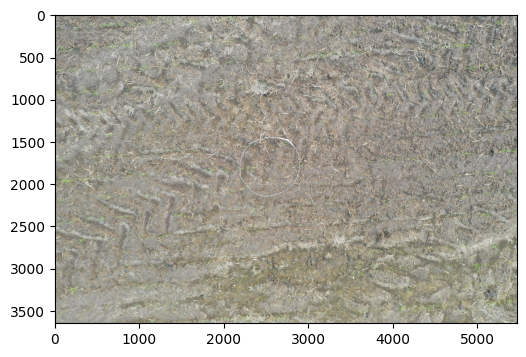

In [196]:
image = cv.imread(image_file)

im = cv.cvtColor(image, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize=(6,4))
plt.imshow(im)
plt.show()

### Labels

In [197]:
labels_file = build_filename(dset=SUBSET, dtype='', name=PROCESSING_FILE) + 'txt'

In [198]:
with open(labels_file, 'r') as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]
    labels = [line.split() for line in lines]

In [199]:
# Convierte de string a int/float
labels = [[int(value) if i == 0 else float(value) 
                for i, value in enumerate(label)] for label in labels]

class_id | x_center | y_center | width | height (normalized values)

In [200]:
df_labels = pd.DataFrame(labels, columns=['class_id', 'x_center', 'y_center', 'width', 'height'])

# Procesamiento

In [201]:
df_labels

class_id  x_center  y_center     width    height
0           0  0.083516  0.099507  0.014254  0.012061
1           0  0.084064  0.106360  0.013158  0.006579
2           0  0.009320  0.110746  0.009503  0.010417
3           0  0.012427  0.110746  0.007675  0.012061
4           0  0.019371  0.108827  0.013523  0.014803
..        ...       ...       ...       ...       ...
912         0  0.913377  0.883498  0.008041  0.020833
913         0  0.924342  0.883224  0.008772  0.018092
914         0  0.933845  0.881579  0.003655  0.019189
915         0  0.940241  0.876645  0.006944  0.005482
916         0  0.960161  0.870614  0.009137  0.008772

[917 rows x 5 columns]

In [202]:
tolerancia_distancia = 0.01  # Ajusta este valor según la dispersión de tus puntos
min_puntos = 5  # Ajusta este valor según la densidad de tus puntos

df_clusters = identificar_clusters(df_labels, tolerancia_distancia, min_puntos)
df_clusters

class_id         x         y  x_rotado  y_rotado  cluster
0           0  0.083516  0.099507  0.076836  0.104751        0
1           0  0.084064  0.106360  0.076935  0.111625        0
2           0  0.009320  0.110746  0.002064  0.111118        0
3           0  0.012427  0.110746  0.005164  0.111321        0
4           0  0.019371  0.108827  0.012219  0.109860        0
..        ...       ...       ...       ...       ...      ...
912         0  0.913377  0.883498  0.853696  0.941291       14
913         0  0.924342  0.883224  0.864655  0.941734       14
914         0  0.933845  0.881579  0.874245  0.940714       14
915         0  0.940241  0.876645  0.880950  0.936208       14
916         0  0.960161  0.870614  0.901222  0.931492       14

[917 rows x 6 columns]

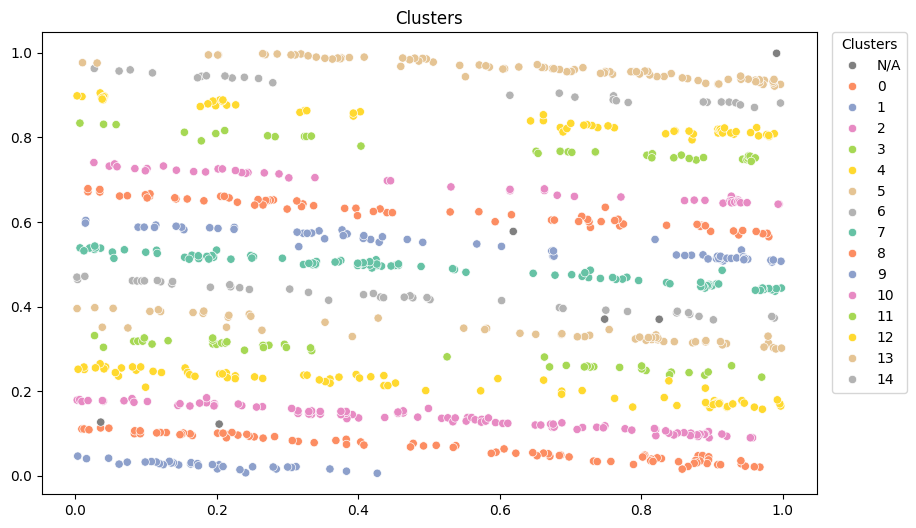

In [203]:
graficar_clusters(df_clusters)

In [204]:
df_lines = identificar_rectas_paralelas(df_clusters)
print(f"Total de líneas detectadas: {len(df_lines)}")

Total de líneas detectadas: 15


In [205]:
df_lines

cluster         m         b
0         0 -0.093063  0.114202
1         1 -0.078435  0.040148
2         2 -0.097226  0.185302
3         3 -0.096788  0.330702
4         4 -0.090202  0.257820
5         5 -0.081035  0.389774
6         6 -0.100364  0.468757
7         7 -0.095039  0.537910
8         8 -0.098326  0.672666
9         9 -0.092500  0.600452
10       10 -0.097792  0.738651
11       11 -0.084677  0.826755
12       12 -0.094926  0.897821
13       13 -0.081535  1.014019
14       14 -0.089094  0.961121

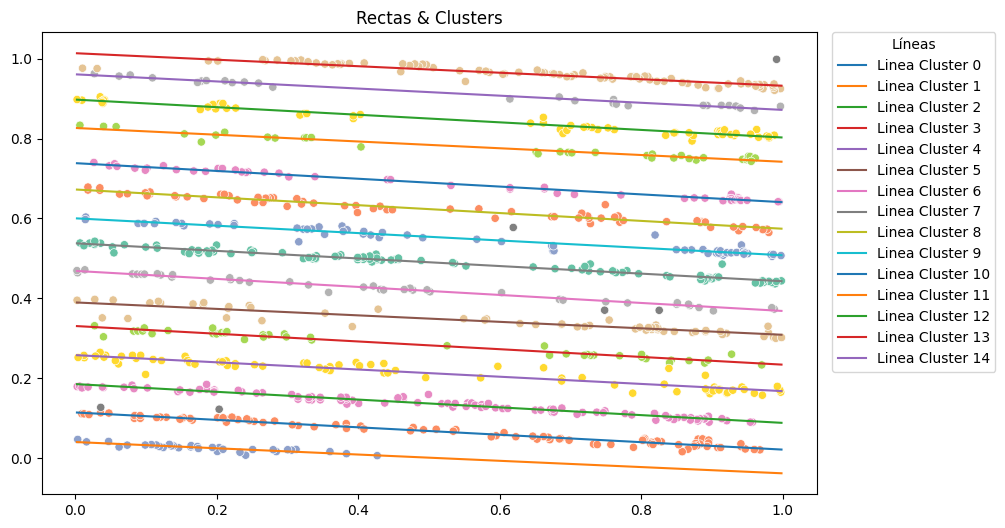

In [206]:
graficar_lineas_clusters(df_clusters, df_lines)

## Eliminar puntos por umbral (maleza)

In [207]:
import pandas as pd
import numpy as np
from scipy import stats

def distancia_punto_recta(punto, recta):
    """Calcula la distancia de un punto a una recta."""
    x, y = punto
    m, b = recta
    A = -m
    B = 1
    C = -b
    distancia = abs(A * x + B * y + C) / np.sqrt(A**2 + B**2)
    return distancia

def calcular_dispersion_cluster(df_cluster, recta):
    """Calcula la dispersión de los puntos de un cluster a la recta."""
    distancias = []
    for _, row in df_cluster.iterrows():
        punto = (row['x'], row['y'])
        distancia = distancia_punto_recta(punto, recta)
        distancias.append(distancia)
    desviacion_estandar = np.std(distancias)
    return desviacion_estandar, distancias

In [208]:
df_clusters

class_id         x         y  x_rotado  y_rotado  cluster
0           0  0.083516  0.099507  0.076836  0.104751        0
1           0  0.084064  0.106360  0.076935  0.111625        0
2           0  0.009320  0.110746  0.002064  0.111118        0
3           0  0.012427  0.110746  0.005164  0.111321        0
4           0  0.019371  0.108827  0.012219  0.109860        0
..        ...       ...       ...       ...       ...      ...
912         0  0.913377  0.883498  0.853696  0.941291       14
913         0  0.924342  0.883224  0.864655  0.941734       14
914         0  0.933845  0.881579  0.874245  0.940714       14
915         0  0.940241  0.876645  0.880950  0.936208       14
916         0  0.960161  0.870614  0.901222  0.931492       14

[917 rows x 6 columns]

In [209]:
# CÁLCULO CON DESVIACION ESTÁNDAR POR LÍNEA (EXCLUYE MÁS PLANTAS)

# Calcular la dispersión y establecer un umbral
umbral = 3.0 # Cantidad de desviaciones estándar (generalmente 3)

print(f"Detectando outliers con umbral: {umbral} desviaciones estándar")
df_clusters['outlier'] = False

for index, row in df_lines.iterrows():
    cluster_id = row['cluster']
    m = row['m']
    b = row['b']
    recta = (m, b)

    df_cluster_indices = df_clusters['cluster'] == cluster_id
    desviacion_estandar, distancias = calcular_dispersion_cluster(df_clusters.loc[df_cluster_indices], recta)

    # Crea las nuevas columnas en df_clusters directamente
    if 'distancia' not in df_clusters.columns:
        df_clusters['distancia'] = np.nan
    if 'desviacion_estandar' not in df_clusters.columns:
        df_clusters['desviacion_estandar'] = np.nan

    # Identificar outliers
    outlier_indices = df_clusters.loc[df_cluster_indices, 'distancia'] > umbral * desviacion_estandar
    outliers = df_clusters.loc[df_cluster_indices][outlier_indices] #filtra las filas que cumplen la condicion.

    # Asigna las métricas a df_clusters directamente
    df_clusters.loc[df_cluster_indices, 'distancia'] = distancias
    df_clusters.loc[df_cluster_indices, 'desviacion_estandar'] = desviacion_estandar
    df_clusters.loc[outliers.index, 'outlier'] = True

    print(f"Cluster {cluster_id:.0f}:")
    print(f"  Desviación estándar: {desviacion_estandar:.5f}")
    print(f"  Outliers detectados: {len(outliers)}\n")

total_outliers = len(df_clusters[df_clusters['outlier'] == True])
df_outliers = df_clusters[df_clusters['outlier'] == True]

print(f"Total de Outliers detectados: {total_outliers}\n")

Detectando outliers con umbral: 3.0 desviaciones estándar
Cluster 0:
  Desviación estándar: 0.00381
  Outliers detectados: 0

Cluster 1:
  Desviación estándar: 0.00281
  Outliers detectados: 0

Cluster 2:
  Desviación estándar: 0.00366
  Outliers detectados: 0

Cluster 3:
  Desviación estándar: 0.00490
  Outliers detectados: 0

Cluster 4:
  Desviación estándar: 0.00836
  Outliers detectados: 0

Cluster 5:
  Desviación estándar: 0.00802
  Outliers detectados: 0

Cluster 6:
  Desviación estándar: 0.00303
  Outliers detectados: 0

Cluster 7:
  Desviación estándar: 0.00473
  Outliers detectados: 0

Cluster 8:
  Desviación estándar: 0.00519
  Outliers detectados: 0

Cluster 9:
  Desviación estándar: 0.00643
  Outliers detectados: 0

Cluster 10:
  Desviación estándar: 0.00264
  Outliers detectados: 0

Cluster 11:
  Desviación estándar: 0.00410
  Outliers detectados: 0

Cluster 12:
  Desviación estándar: 0.00485
  Outliers detectados: 0

Cluster 13:
  Desviación estándar: 0.00638
  Outliers d

In [210]:
df_outliers

Empty DataFrame
Columns: [class_id, x, y, x_rotado, y_rotado, cluster, outlier, distancia, desviacion_estandar]
Index: []

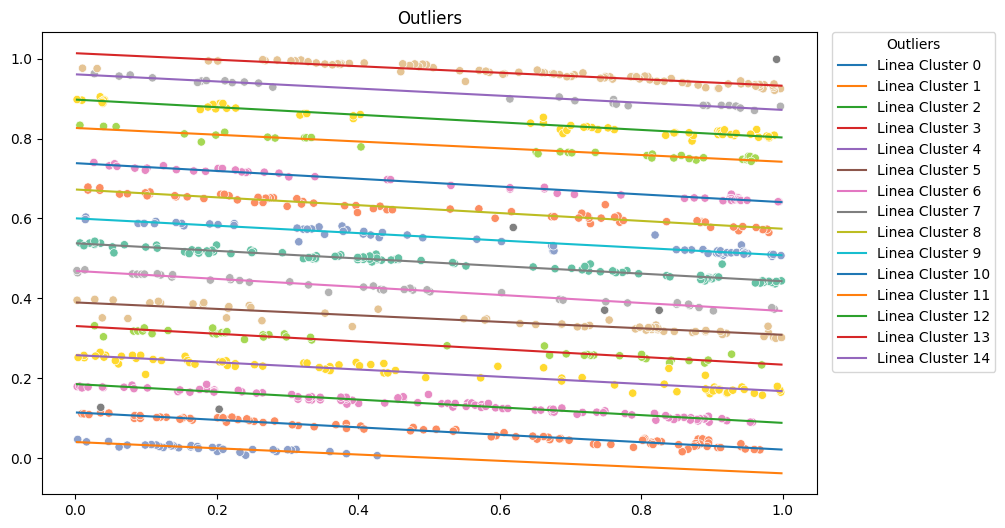

In [211]:
graficar_outliers(df_clusters, df_lines, df_outliers)

In [212]:
# CÁLCULO CON DESVIACION ESTÁNDAR MEDIA (EVITA SESGOS POR DISPERSION EN LÍNEAS)

# Calcular la dispersión y establecer un umbral
umbral = 3.0 # Cantidad de desviaciones estándar (generalmente 3)

print(f"Detectando outliers con umbral: {umbral} desviaciones estándar")
df_clusters['outlier'] = False

for index, row in df_lines.iterrows():
    cluster_id = row['cluster']

    # Calcula la recta
    m = row['m']
    b = row['b']
    recta = (m, b)

    # Calcula la dispersión para cada punto
    df_cluster_indices = df_clusters['cluster'] == cluster_id
    desviacion_estandar, distancias = calcular_dispersion_cluster(df_clusters.loc[df_cluster_indices], recta)

    # Crea las nuevas columnas en df_clusters directamente
    if 'distancia' not in df_clusters.columns:
        df_clusters['distancia'] = np.nan
    if 'desviacion_estandar' not in df_clusters.columns:
        df_clusters['desviacion_estandar'] = np.nan

    # Asigna las métricas al DataFrame
    df_clusters.loc[df_cluster_indices, 'distancia'] = distancias
    df_clusters.loc[df_cluster_indices, 'desviacion_estandar'] = desviacion_estandar

df_lines = pd.merge(df_lines,df_clusters[['cluster','desviacion_estandar']].drop_duplicates(),how='left')
desviacion_estandar_media = df_lines['desviacion_estandar'].mean()
print(f"Desviación estándar media: {desviacion_estandar_media}\n")

# VERIFICACIÓN DE PERTENENCIA A CLUSTERS
for index, row in df_lines.iterrows():
    cluster_id = row['cluster']
    df_cluster_indices = df_clusters['cluster'] == cluster_id

    # Identificar outliers
    outlier_indices = df_clusters.loc[df_cluster_indices, 'distancia'] > umbral * desviacion_estandar_media
    outliers = df_clusters.loc[df_cluster_indices][outlier_indices] #filtra las filas que cumplen la condicion.

    # Asigna las métricas al DataFrame
    df_clusters.loc[outliers.index, 'outlier'] = True

    print(f"Cluster {cluster_id:.0f}:")
    print(f"  Desviación estándar: {desviacion_estandar:.5f}")
    print(f"  Outliers detectados: {len(outliers)}\n")

total_outliers = len(df_clusters[df_clusters['outlier'] == True])
df_outliers = df_clusters[df_clusters['outlier'] == True]

print(f"Total de Outliers detectados: {total_outliers}\n")

Detectando outliers con umbral: 3.0 desviaciones estándar
Desviación estándar media: 0.004755675664920891

Cluster 0:
  Desviación estándar: 0.00243
  Outliers detectados: 3

Cluster 1:
  Desviación estándar: 0.00243
  Outliers detectados: 0

Cluster 2:
  Desviación estándar: 0.00243
  Outliers detectados: 2

Cluster 3:
  Desviación estándar: 0.00243
  Outliers detectados: 2

Cluster 4:
  Desviación estándar: 0.00243
  Outliers detectados: 11

Cluster 5:
  Desviación estándar: 0.00243
  Outliers detectados: 8

Cluster 6:
  Desviación estándar: 0.00243
  Outliers detectados: 1

Cluster 7:
  Desviación estándar: 0.00243
  Outliers detectados: 4

Cluster 8:
  Desviación estándar: 0.00243
  Outliers detectados: 2

Cluster 9:
  Desviación estándar: 0.00243
  Outliers detectados: 6

Cluster 10:
  Desviación estándar: 0.00243
  Outliers detectados: 0

Cluster 11:
  Desviación estándar: 0.00243
  Outliers detectados: 1

Cluster 12:
  Desviación estándar: 0.00243
  Outliers detectados: 4

Clust

In [213]:
df_outliers

class_id         x         y  x_rotado  y_rotado  cluster  outlier  \
137         0  0.880482  0.047423  0.875502  0.104854        0     True   
138         0  0.886696  0.047971  0.881666  0.105807        0     True   
147         0  0.858004  0.015899  0.855132  0.071929        0     True   
188         0  0.061038  0.235746  0.045504  0.239230        4     True   
191         0  0.039839  0.303728  0.019908  0.305682        3     True   
..        ...       ...       ...       ...       ...      ...      ...   
771         0  0.963268  0.822917  0.907438  0.884100       12     True   
783         0  0.010234  0.976425 -0.053589  0.975007       13     True   
785         0  0.030885  0.975603 -0.032929  0.975536       13     True   
838         0  0.551535  0.943257  0.488722  0.977279       13     True   
859         0  0.661732  0.853344  0.604559  0.894759       12     True   

     distancia  desviacion_estandar  
137   0.015096             0.003806  
138   0.016218             0.003806  
147   0.018375             0.003806  
188   0.016501             0.008360  
191   0.023010             0.004903  
..         ...                  ...  
771   0.016461             0.004849  
783   0.036638             0.006377  
785   0.035779             0.006377  
838   0.025708             0.006377  
859   0.018257             0.004849  

[47 rows x 9 columns]

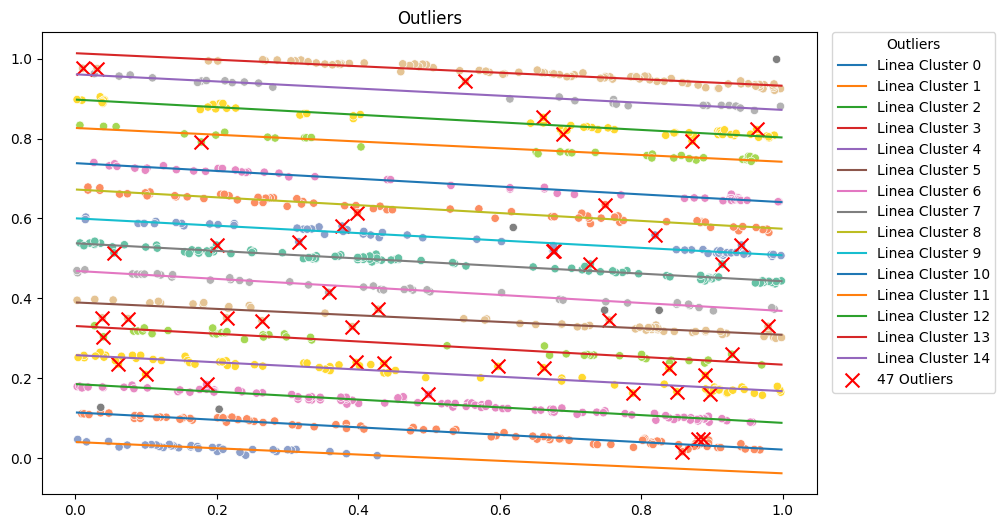

In [214]:
graficar_outliers(df_clusters, df_lines, df_outliers)

Podemos ver que, dado que los puntos presenta gran dispersión, con un umbral de 3 desviaciones estándar no es suficiente, ya que excluye algunas plantas que pertenecen al zurco. 

In [215]:
# CÁLCULO CON DESVIACION ESTÁNDAR MEDIA (EVITA SESGOS POR DISPERSION EN LÍNEAS)

# Calcular la dispersión y establecer un umbral
umbral = 4.0 # Cantidad de desviaciones estándar (generalmente 3)

print(f"Detectando outliers con umbral: {umbral} desviaciones estándar")
df_clusters['outlier'] = False

for index, row in df_lines.iterrows():
    cluster_id = row['cluster']

    # Calcula la recta
    m = row['m']
    b = row['b']
    recta = (m, b)

    # Calcula la dispersión para cada punto
    df_cluster_indices = df_clusters['cluster'] == cluster_id
    desviacion_estandar, distancias = calcular_dispersion_cluster(df_clusters.loc[df_cluster_indices], recta)

    # Crea las nuevas columnas en df_clusters directamente
    if 'distancia' not in df_clusters.columns:
        df_clusters['distancia'] = np.nan
    if 'desviacion_estandar' not in df_clusters.columns:
        df_clusters['desviacion_estandar'] = np.nan

    # Asigna las métricas al DataFrame
    df_clusters.loc[df_cluster_indices, 'distancia'] = distancias
    df_clusters.loc[df_cluster_indices, 'desviacion_estandar'] = desviacion_estandar

df_lines = pd.merge(df_lines,df_clusters[['cluster','desviacion_estandar']].drop_duplicates(),how='left')
desviacion_estandar_media = df_lines['desviacion_estandar'].mean()
print(f"Desviación estándar media: {desviacion_estandar_media}\n")

# VERIFICACIÓN DE PERTENENCIA A CLUSTERS
for index, row in df_lines.iterrows():
    cluster_id = row['cluster']
    df_cluster_indices = df_clusters['cluster'] == cluster_id

    # Identificar outliers
    outlier_indices = df_clusters.loc[df_cluster_indices, 'distancia'] > umbral * desviacion_estandar_media
    outliers = df_clusters.loc[df_cluster_indices][outlier_indices] #filtra las filas que cumplen la condicion.

    # Asigna las métricas al DataFrame
    df_clusters.loc[outliers.index, 'outlier'] = True

    print(f"Cluster {cluster_id:.0f}:")
    print(f"  Desviación estándar: {desviacion_estandar:.5f}")
    print(f"  Outliers detectados: {len(outliers)}\n")

total_outliers = len(df_clusters[df_clusters['outlier'] == True])
df_outliers = df_clusters[df_clusters['outlier'] == True]

print(f"Total de Outliers detectados: {total_outliers}\n")

Detectando outliers con umbral: 4.0 desviaciones estándar
Desviación estándar media: 0.004755675664920891

Cluster 0:
  Desviación estándar: 0.00243
  Outliers detectados: 0

Cluster 1:
  Desviación estándar: 0.00243
  Outliers detectados: 0

Cluster 2:
  Desviación estándar: 0.00243
  Outliers detectados: 1

Cluster 3:
  Desviación estándar: 0.00243
  Outliers detectados: 2

Cluster 4:
  Desviación estándar: 0.00243
  Outliers detectados: 6

Cluster 5:
  Desviación estándar: 0.00243
  Outliers detectados: 6

Cluster 6:
  Desviación estándar: 0.00243
  Outliers detectados: 0

Cluster 7:
  Desviación estándar: 0.00243
  Outliers detectados: 1

Cluster 8:
  Desviación estándar: 0.00243
  Outliers detectados: 1

Cluster 9:
  Desviación estándar: 0.00243
  Outliers detectados: 3

Cluster 10:
  Desviación estándar: 0.00243
  Outliers detectados: 0

Cluster 11:
  Desviación estándar: 0.00243
  Outliers detectados: 1

Cluster 12:
  Desviación estándar: 0.00243
  Outliers detectados: 2

Cluste

In [216]:
df_outliers

class_id         x         y  x_rotado  y_rotado  cluster  outlier  \
191         0  0.039839  0.303728  0.019908  0.305682        3     True   
225         0  0.099415  0.209430  0.085518  0.215478        4     True   
280         0  0.499269  0.159265  0.487795  0.191548        2     True   
282         0  0.597405  0.229715  0.581118  0.268259        4     True   
284         0  0.662098  0.226151  0.645906  0.268931        4     True   
..        ...       ...       ...       ...       ...      ...      ...   
741         0  0.689510  0.812774  0.634929  0.856091       12     True   
755         0  0.871893  0.794134  0.818140  0.849408       12     True   
783         0  0.010234  0.976425 -0.053589  0.975007       13     True   
785         0  0.030885  0.975603 -0.032929  0.975536       13     True   
838         0  0.551535  0.943257  0.488722  0.977279       13     True   

     distancia  desviacion_estandar  
191   0.023010             0.004903  
225   0.039263             0.008360  
280   0.022400             0.003662  
282   0.025678             0.008360  
284   0.027941             0.008360  
..         ...                  ...  
741   0.019507             0.004849  
755   0.020828             0.004849  
783   0.036638             0.006377  
785   0.035779             0.006377  
838   0.025708             0.006377  

[26 rows x 9 columns]

Se han identificado un total de 26 potenciales outliers.

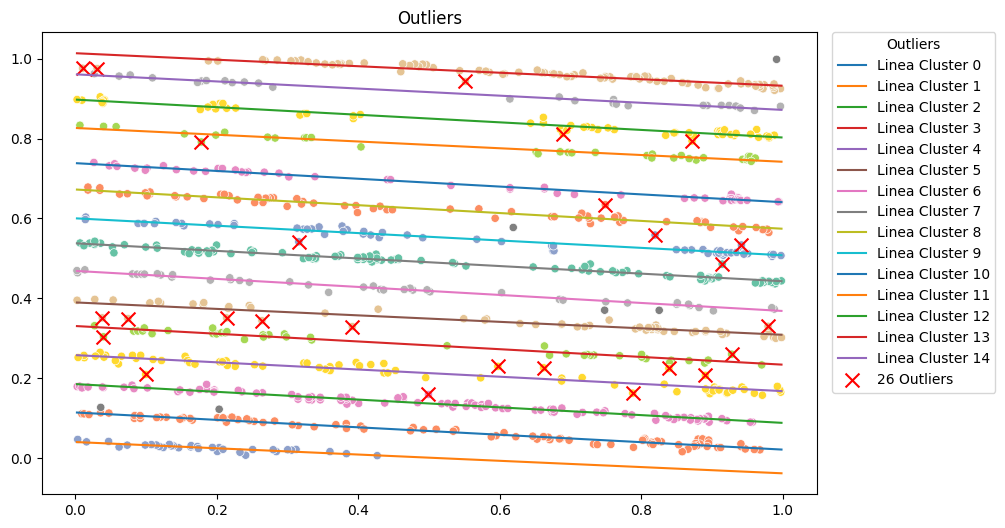

In [217]:
graficar_outliers(df_clusters, df_lines, df_outliers)

Utilizando un umbrar de 4 desviaciones estándar se consigue filtrar todas aquellas plantas que se encuentran entre dos zurcos (claramente malezas o arroz guacho).

# Conteo parcial (Output del modelo)

In [218]:
df_labels

class_id  x_center  y_center     width    height
0           0  0.083516  0.099507  0.014254  0.012061
1           0  0.084064  0.106360  0.013158  0.006579
2           0  0.009320  0.110746  0.009503  0.010417
3           0  0.012427  0.110746  0.007675  0.012061
4           0  0.019371  0.108827  0.013523  0.014803
..        ...       ...       ...       ...       ...
912         0  0.913377  0.883498  0.008041  0.020833
913         0  0.924342  0.883224  0.008772  0.018092
914         0  0.933845  0.881579  0.003655  0.019189
915         0  0.940241  0.876645  0.006944  0.005482
916         0  0.960161  0.870614  0.009137  0.008772

[917 rows x 5 columns]

In [219]:
df_clusters.count()

class_id               917
x                      917
y                      917
x_rotado               917
y_rotado               917
cluster                917
outlier                917
distancia              911
desviacion_estandar    911
dtype: int64

In [220]:
df_labels = pd.merge(df_labels,df_clusters[['cluster','outlier']],how='left', left_index=True, right_index=True)
df_labels['cluster'] = df_labels['cluster'].astype(int)
df_labels

class_id  x_center  y_center     width    height  cluster  outlier
0           0  0.083516  0.099507  0.014254  0.012061        0    False
1           0  0.084064  0.106360  0.013158  0.006579        0    False
2           0  0.009320  0.110746  0.009503  0.010417        0    False
3           0  0.012427  0.110746  0.007675  0.012061        0    False
4           0  0.019371  0.108827  0.013523  0.014803        0    False
..        ...       ...       ...       ...       ...      ...      ...
912         0  0.913377  0.883498  0.008041  0.020833       14    False
913         0  0.924342  0.883224  0.008772  0.018092       14    False
914         0  0.933845  0.881579  0.003655  0.019189       14    False
915         0  0.940241  0.876645  0.006944  0.005482       14    False
916         0  0.960161  0.870614  0.009137  0.008772       14    False

[917 rows x 7 columns]

In [221]:
df_clusters

class_id         x         y  x_rotado  y_rotado  cluster  outlier  \
0           0  0.083516  0.099507  0.076836  0.104751        0    False   
1           0  0.084064  0.106360  0.076935  0.111625        0    False   
2           0  0.009320  0.110746  0.002064  0.111118        0    False   
3           0  0.012427  0.110746  0.005164  0.111321        0    False   
4           0  0.019371  0.108827  0.012219  0.109860        0    False   
..        ...       ...       ...       ...       ...      ...      ...   
912         0  0.913377  0.883498  0.853696  0.941291       14    False   
913         0  0.924342  0.883224  0.864655  0.941734       14    False   
914         0  0.933845  0.881579  0.874245  0.940714       14    False   
915         0  0.940241  0.876645  0.880950  0.936208       14    False   
916         0  0.960161  0.870614  0.901222  0.931492       14    False   

     distancia  desviacion_estandar  
0     0.006893             0.003806  
1     0.000019             0.003806  
2     0.002578             0.003806  
3     0.002290             0.003806  
4     0.003557             0.003806  
..         ...                  ...  
912   0.003738             0.002432  
913   0.004438             0.002432  
914   0.003644             0.002432  
915   0.000704             0.002432  
916   0.004943             0.002432  

[917 rows x 9 columns]

In [222]:
df_clusters = df_clusters.dropna()
df_plants = df_labels.loc[df_labels['id_linea'].isin(df_clusters['id_linea'])]
n_plants = len(df_plants)
print(f"Se han detectado un total de {n_plants} plantas.")
df_plants

KeyError: 'id_linea'

## Asignación de outliers a rectas adyacentes

El otro problema a resolver es que al usar DBSCAN algunos puntos son erróneamente asignados a rectas. Para solucionar esto, lo que haremos será asignar cada outlier a la recta inmediata adyacente y volver a verificar si pertenecen a dicha recta (falsos positivos = no serían outliers).

Se ordenan las líneas (de forma perpendicular) y se crea un nuevo índice para poder reasignar los puntos a la línea adyacente.

In [ ]:
df_lines.sort_values(by='b', ascending=False,ignore_index=True,inplace=True)
df_lines.reset_index(inplace=True)
df_lines.rename(columns={'index': 'id_linea'}, inplace=True)

In [ ]:
df_lines

id_linea  cluster         m         b  desviacion_estandar
0          0       13 -0.081535  1.014019             0.006377
1          1       14 -0.089094  0.961121             0.002432
2          2       12 -0.094926  0.897821             0.004849
3          3       11 -0.084677  0.826755             0.004096
4          4       10 -0.097792  0.738651             0.002643
5          5        8 -0.098326  0.672666             0.005189
6          6        9 -0.092500  0.600452             0.006434
7          7        7 -0.095039  0.537910             0.004726
8          8        6 -0.100364  0.468757             0.003028
9          9        5 -0.081035  0.389774             0.008023
10        10        3 -0.096788  0.330702             0.004903
11        11        4 -0.090202  0.257820             0.008360
12        12        2 -0.097226  0.185302             0.003662
13        13        0 -0.093063  0.114202             0.003806
14        14        1 -0.078435  0.040148             0.002808

Se agrega dicho índice al DataFrame de outliers.

In [ ]:
df_outliers = df_outliers.reset_index()
df_outliers_fp = pd.merge(df_outliers, df_lines[['cluster', 'id_linea', 'b']], on='cluster', how='left')
df_outliers_fp = df_outliers_fp.set_index('index')

In [ ]:
# Se ordenan los outliers para simplificar su procesamiento
df_outliers_fp.sort_values(by='id_linea',inplace=True)
df_outliers_fp

class_id         x         y  x_rotado  y_rotado  cluster  outlier  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536       13     True   
838           0  0.551535  0.943257  0.488722  0.977279       13     True   
783           0  0.010234  0.976425 -0.053589  0.975007       13     True   
741           0  0.689510  0.812774  0.634929  0.856091       12     True   
755           0  0.871893  0.794134  0.818140  0.849408       12     True   
...         ...       ...       ...       ...       ...      ...      ...   
287           0  0.788012  0.162555  0.775706  0.213697        4     True   
284           0  0.662098  0.226151  0.645906  0.268931        4     True   
225           0  0.099415  0.209430  0.085518  0.215478        4     True   
309           0  0.890716  0.207237  0.875272  0.264995        4     True   
280           0  0.499269  0.159265  0.487795  0.191548        2     True   

       distancia  desviacion_estandar  id_linea         b  
index                                                      
785     0.035779             0.006377         0  1.014019  
838     0.025708             0.006377         0  1.014019  
783     0.036638             0.006377         0  1.014019  
741     0.019507             0.004849         2  0.897821  
755     0.020828             0.004849         2  0.897821  
...          ...                  ...       ...       ...  
287     0.024087             0.008360        11  0.257820  
284     0.027941             0.008360        11  0.257820  
225     0.039263             0.008360        11  0.257820  
309     0.029641             0.008360        11  0.257820  
280     0.022400             0.003662        12  0.185302  

[26 rows x 11 columns]

Se compara la posición del punto respecto a "su recta" para determinar si está por encima o por debajo de la misma, y luego poder reasignarlo a la línea inmediata siguiente.

In [ ]:
def linea_adyacente(row):
    y = row['y_rotado']
    b = row['b']
    print(f"cluster: {row['cluster']} con orden {row['id_linea']}")
    print("y rotado:", y)
    print("y línea:", b)
    if y > b:
        print(">> Arriba de la Linea")
        row['id_linea'] -= 1
    else:
        print(">> Debajo de la línea")
        row['id_linea'] += 1
    print(f"Mover al cluster con orden {row['id_linea']}")
    print()
    return row

In [ ]:
df_outliers_fp = df_outliers_fp.apply(linea_adyacente, axis=1)

cluster: 13 con orden 0
y rotado: 0.9755362014264479
y línea: 1.0140190292880356
>> Debajo de la línea
Mover al cluster con orden 1

cluster: 13 con orden 0
y rotado: 0.977279027724894
y línea: 1.0140190292880356
>> Debajo de la línea
Mover al cluster con orden 1

cluster: 13 con orden 0
y rotado: 0.9750074682028708
y línea: 1.0140190292880356
>> Debajo de la línea
Mover al cluster con orden 1

cluster: 12 con orden 2
y rotado: 0.8560909492149565
y línea: 0.8978213493570358
>> Debajo de la línea
Mover al cluster con orden 3

cluster: 12 con orden 2
y rotado: 0.8494076506586582
y línea: 0.8978213493570358
>> Debajo de la línea
Mover al cluster con orden 3

cluster: 11 con orden 3
y rotado: 0.8016174054687681
y línea: 0.8267548353328902
>> Debajo de la línea
Mover al cluster con orden 4

cluster: 8 con orden 5
y rotado: 0.6821966436176329
y línea: 0.6726661495938615
>> Arriba de la Linea
Mover al cluster con orden 4

cluster: 9 con orden 6
y rotado: 0.5941090078162261
y línea: 0.60045242

In [ ]:
df_outliers_fp

class_id         x         y  x_rotado  y_rotado  cluster  outlier  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536       13     True   
838           0  0.551535  0.943257  0.488722  0.977279       13     True   
783           0  0.010234  0.976425 -0.053589  0.975007       13     True   
741           0  0.689510  0.812774  0.634929  0.856091       12     True   
755           0  0.871893  0.794134  0.818140  0.849408       12     True   
...         ...       ...       ...       ...       ...      ...      ...   
287           0  0.788012  0.162555  0.775706  0.213697        4     True   
284           0  0.662098  0.226151  0.645906  0.268931        4     True   
225           0  0.099415  0.209430  0.085518  0.215478        4     True   
309           0  0.890716  0.207237  0.875272  0.264995        4     True   
280           0  0.499269  0.159265  0.487795  0.191548        2     True   

       distancia  desviacion_estandar  id_linea         b  
index                                                      
785     0.035779             0.006377         1  1.014019  
838     0.025708             0.006377         1  1.014019  
783     0.036638             0.006377         1  1.014019  
741     0.019507             0.004849         3  0.897821  
755     0.020828             0.004849         3  0.897821  
...          ...                  ...       ...       ...  
287     0.024087             0.008360        12  0.257820  
284     0.027941             0.008360        10  0.257820  
225     0.039263             0.008360        12  0.257820  
309     0.029641             0.008360        10  0.257820  
280     0.022400             0.003662        11  0.185302  

[26 rows x 11 columns]

In [ ]:
# Reemplaza por las asignaciones de cluster actualizadas
df_clusters_fp = df_clusters.copy()
df_clusters_fp.iloc[df_outliers_fp.index, df_clusters_fp.columns.get_loc('cluster')] = df_outliers_fp['cluster'].values

## Verificación de outliers para el cluster adyacente

Se asigna el cluster correspondiente al nuevo `id_linea` calculado.

In [ ]:
df_outliers_fp = df_outliers_fp.reset_index()
df_outliers_fp = pd.merge(df_outliers_fp, df_lines[['id_linea', 'cluster']], on='id_linea', how='left', suffixes=('_outliers', '_lines'))
df_outliers_fp['cluster'] = df_outliers_fp['cluster_lines']
df_outliers_fp.drop('cluster_lines', axis=1, inplace=True)
df_outliers_fp.rename(columns={'cluster_outliers': 'cluster_original'},inplace=True)
df_outliers_fp = df_outliers_fp.set_index('index')

In [ ]:
df_outliers_fp

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536                13   
838           0  0.551535  0.943257  0.488722  0.977279                13   
783           0  0.010234  0.976425 -0.053589  0.975007                13   
741           0  0.689510  0.812774  0.634929  0.856091                12   
755           0  0.871893  0.794134  0.818140  0.849408                12   
...         ...       ...       ...       ...       ...               ...   
287           0  0.788012  0.162555  0.775706  0.213697                 4   
284           0  0.662098  0.226151  0.645906  0.268931                 4   
225           0  0.099415  0.209430  0.085518  0.215478                 4   
309           0  0.890716  0.207237  0.875272  0.264995                 4   
280           0  0.499269  0.159265  0.487795  0.191548                 2   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
785       True   0.035779             0.006377         1  1.014019       14  
838       True   0.025708             0.006377         1  1.014019       14  
783       True   0.036638             0.006377         1  1.014019       14  
741       True   0.019507             0.004849         3  0.897821       11  
755       True   0.020828             0.004849         3  0.897821       11  
...        ...        ...                  ...       ...       ...      ...  
287       True   0.024087             0.008360        12  0.257820        2  
284       True   0.027941             0.008360        10  0.257820        3  
225       True   0.039263             0.008360        12  0.257820        2  
309       True   0.029641             0.008360        10  0.257820        3  
280       True   0.022400             0.003662        11  0.185302        4  

[26 rows x 12 columns]

In [ ]:
graficar_clusters(df_clusters_fp)

NameError: name 'df_clusters_fp' is not defined

In [ ]:
# VERIFICACIÓN DE PERTENENCIA A CLUSTERS

print(f"Detectando outliers con umbral: {umbral} desviaciones estándar")
df_outliers_fp['outlier'] = False

desviacion_estandar_media = df_clusters['desviacion_estandar'].mean()
print(f"Desviación estándar media: {desviacion_estandar_media}\n")

for index, row in df_lines.iterrows():
    cluster_id = row['cluster']
    df_cluster_indices = df_outliers_fp['cluster'] == cluster_id
    desviacion_estandar = df_lines[df_lines['cluster'] == cluster_id]['desviacion_estandar'].values[0]

    # Identificar outliers
    outlier_indices = df_outliers_fp.loc[df_cluster_indices, 'distancia'] > umbral * desviacion_estandar_media
    outliers = df_outliers_fp.loc[df_cluster_indices][outlier_indices] #filtra las filas que cumplen la condicion.

    # Asigna las métricas al DataFrame
    df_outliers_fp.loc[outliers.index, 'outlier'] = True
    print(f"Cluster {cluster_id:.0f}:")
    print(f"  Desviación estándar: {desviacion_estandar:.5f}")
    print(f"  Outliers detectados: {len(outliers)}\n")

total_outliers = len(df_outliers_fp[df_outliers_fp['outlier'] == True])
df_outliers = df_outliers_fp[df_outliers_fp['outlier'] == True]

print(f"Total de Outliers detectados: {total_outliers}\n")

Detectando outliers con umbral: 4.0 desviaciones estándar
Desviación estándar media: 0.005000196960851508

Cluster 13:
  Desviación estándar: 0.00638
  Outliers detectados: 0

Cluster 14:
  Desviación estándar: 0.00243
  Outliers detectados: 3

Cluster 12:
  Desviación estándar: 0.00485
  Outliers detectados: 0

Cluster 11:
  Desviación estándar: 0.00410
  Outliers detectados: 1

Cluster 10:
  Desviación estándar: 0.00264
  Outliers detectados: 1

Cluster 8:
  Desviación estándar: 0.00519
  Outliers detectados: 1

Cluster 9:
  Desviación estándar: 0.00643
  Outliers detectados: 1

Cluster 7:
  Desviación estándar: 0.00473
  Outliers detectados: 2

Cluster 6:
  Desviación estándar: 0.00303
  Outliers detectados: 0

Cluster 5:
  Desviación estándar: 0.00802
  Outliers detectados: 0

Cluster 3:
  Desviación estándar: 0.00490
  Outliers detectados: 9

Cluster 4:
  Desviación estándar: 0.00836
  Outliers detectados: 2

Cluster 2:
  Desviación estándar: 0.00366
  Outliers detectados: 2

Clus

In [ ]:
graficar_outliers(df_clusters_fp, df_lines, df_outliers_fp)

NameError: name 'df_clusters_fp' is not defined

Sólo aquellos objetos que fueron detectados como outliers para ambas líneas, son realmente outliers (verdaderos positivios). Los demás fueron errónemanete asignados desde un principio (falsos positivos).

In [ ]:
# DEBEN SER REASIGNADOS A SU CLUSTER
falsos_positivos = df_outliers_fp[df_outliers_fp['outlier']==False]
falsos_positivos

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
741           0  0.689510  0.812774  0.634929  0.856091                12   
694           0  0.178180  0.791667  0.126070  0.801617                11   
488           0  0.979349  0.330044  0.955691  0.393331                 5   
338           0  0.927814  0.260143  0.908833  0.320212                 3   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
741      False   0.019507             0.004849         3  0.897821       11  
694      False   0.019929             0.004096         4  0.826755       10  
488      False   0.019568             0.008023         8  0.389774        6  
338      False   0.019152             0.004903        11  0.330702        4

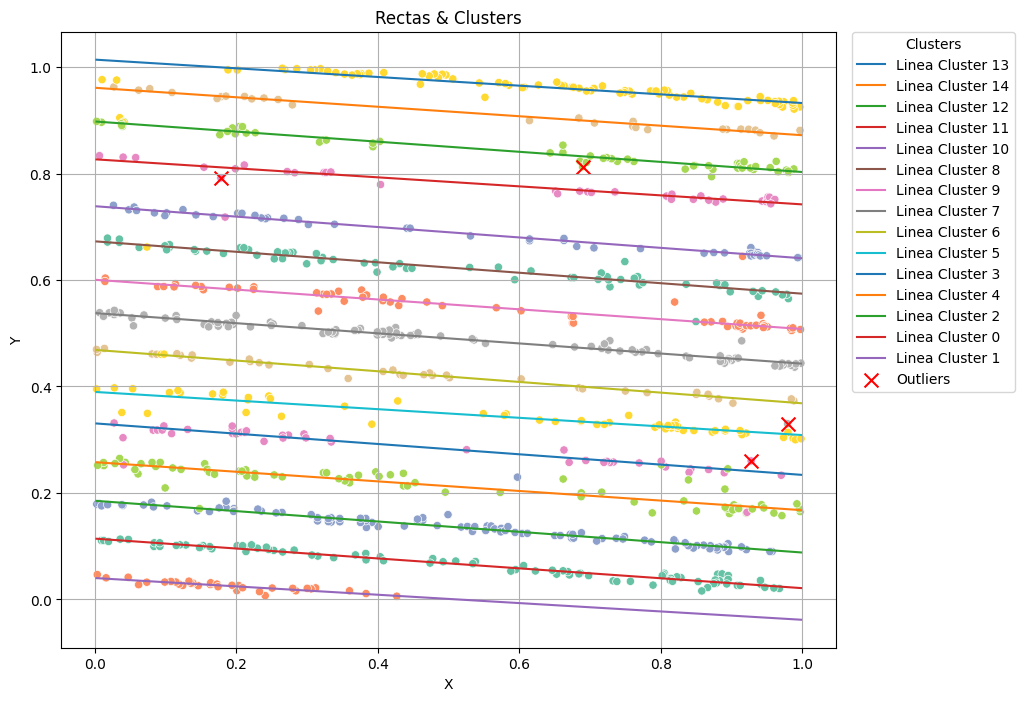

In [ ]:
# FALSOS POSITIVOS
# Estos objetos se han sido detectado de forma erróneas (pertenecen a la línea adyacente)
graficar_outliers(df_clusters_fp, df_lines, falsos_positivos)

In [ ]:
# VERDADREOS POSITIVOS (OUTLIERS REALES)
verdaderos_positivos = df_outliers_fp[df_outliers_fp['outlier']==True]
verdaderos_positivos

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536                13   
838           0  0.551535  0.943257  0.488722  0.977279                13   
783           0  0.010234  0.976425 -0.053589  0.975007                13   
755           0  0.871893  0.794134  0.818140  0.849408                12   
622           0  0.749269  0.634594  0.706202  0.682197                 8   
...         ...       ...       ...       ...       ...               ...   
287           0  0.788012  0.162555  0.775706  0.213697                 4   
284           0  0.662098  0.226151  0.645906  0.268931                 4   
225           0  0.099415  0.209430  0.085518  0.215478                 4   
309           0  0.890716  0.207237  0.875272  0.264995                 4   
280           0  0.499269  0.159265  0.487795  0.191548                 2   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
785       True   0.035779             0.006377         1  1.014019       14  
838       True   0.025708             0.006377         1  1.014019       14  
783       True   0.036638             0.006377         1  1.014019       14  
755       True   0.020828             0.004849         3  0.897821       11  
622       True   0.035430             0.005189         4  0.672666       10  
...        ...        ...                  ...       ...       ...      ...  
287       True   0.024087             0.008360        12  0.257820        2  
284       True   0.027941             0.008360        10  0.257820        3  
225       True   0.039263             0.008360        12  0.257820        2  
309       True   0.029641             0.008360        10  0.257820        3  
280       True   0.022400             0.003662        11  0.185302        4  

[22 rows x 12 columns]

In [ ]:
# Estos objetos se han identificado como clasificaciones erróneas (pertenecen a la línea adyacente)
graficar_outliers(df_clusters_fp, df_lines, verdaderos_positivos)

NameError: name 'df_clusters_fp' is not defined

---
---

# TESTING

In [ ]:
df_clusters

class_id         x         y  x_rotado  y_rotado  cluster  outlier  \
0           0  0.083516  0.099507  0.076836  0.104751        0    False   
1           0  0.084064  0.106360  0.076935  0.111625        0    False   
2           0  0.009320  0.110746  0.002064  0.111118        0    False   
3           0  0.012427  0.110746  0.005164  0.111321        0    False   
4           0  0.019371  0.108827  0.012219  0.109860        0    False   
..        ...       ...       ...       ...       ...      ...      ...   
912         0  0.913377  0.883498  0.853696  0.941291       14    False   
913         0  0.924342  0.883224  0.864655  0.941734       14    False   
914         0  0.933845  0.881579  0.874245  0.940714       14    False   
915         0  0.940241  0.876645  0.880950  0.936208       14    False   
916         0  0.960161  0.870614  0.901222  0.931492       14    False   

     distancia  desviacion_estandar  
0     0.006893             0.003806  
1     0.000019             0.003806  
2     0.002578             0.003806  
3     0.002290             0.003806  
4     0.003557             0.003806  
..         ...                  ...  
912   0.003738             0.002432  
913   0.004438             0.002432  
914   0.003644             0.002432  
915   0.000704             0.002432  
916   0.004943             0.002432  

[911 rows x 9 columns]

In [ ]:
df_outliers

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536                13   
838           0  0.551535  0.943257  0.488722  0.977279                13   
783           0  0.010234  0.976425 -0.053589  0.975007                13   
755           0  0.871893  0.794134  0.818140  0.849408                12   
622           0  0.749269  0.634594  0.706202  0.682197                 8   
...         ...       ...       ...       ...       ...               ...   
287           0  0.788012  0.162555  0.775706  0.213697                 4   
284           0  0.662098  0.226151  0.645906  0.268931                 4   
225           0  0.099415  0.209430  0.085518  0.215478                 4   
309           0  0.890716  0.207237  0.875272  0.264995                 4   
280           0  0.499269  0.159265  0.487795  0.191548                 2   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
785       True   0.035779             0.006377         1  1.014019       14  
838       True   0.025708             0.006377         1  1.014019       14  
783       True   0.036638             0.006377         1  1.014019       14  
755       True   0.020828             0.004849         3  0.897821       11  
622       True   0.035430             0.005189         4  0.672666       10  
...        ...        ...                  ...       ...       ...      ...  
287       True   0.024087             0.008360        12  0.257820        2  
284       True   0.027941             0.008360        10  0.257820        3  
225       True   0.039263             0.008360        12  0.257820        2  
309       True   0.029641             0.008360        10  0.257820        3  
280       True   0.022400             0.003662        11  0.185302        4  

[22 rows x 12 columns]

In [ ]:
df_outliers_fp

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536                13   
838           0  0.551535  0.943257  0.488722  0.977279                13   
783           0  0.010234  0.976425 -0.053589  0.975007                13   
741           0  0.689510  0.812774  0.634929  0.856091                12   
755           0  0.871893  0.794134  0.818140  0.849408                12   
...         ...       ...       ...       ...       ...               ...   
287           0  0.788012  0.162555  0.775706  0.213697                 4   
284           0  0.662098  0.226151  0.645906  0.268931                 4   
225           0  0.099415  0.209430  0.085518  0.215478                 4   
309           0  0.890716  0.207237  0.875272  0.264995                 4   
280           0  0.499269  0.159265  0.487795  0.191548                 2   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
785       True   0.035779             0.006377         1  1.014019       14  
838       True   0.025708             0.006377         1  1.014019       14  
783       True   0.036638             0.006377         1  1.014019       14  
741      False   0.019507             0.004849         3  0.897821       11  
755       True   0.020828             0.004849         3  0.897821       11  
...        ...        ...                  ...       ...       ...      ...  
287       True   0.024087             0.008360        12  0.257820        2  
284       True   0.027941             0.008360        10  0.257820        3  
225       True   0.039263             0.008360        12  0.257820        2  
309       True   0.029641             0.008360        10  0.257820        3  
280       True   0.022400             0.003662        11  0.185302        4  

[26 rows x 12 columns]

In [ ]:
falsos_positivos.head()

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
741           0  0.689510  0.812774  0.634929  0.856091                12   
694           0  0.178180  0.791667  0.126070  0.801617                11   
488           0  0.979349  0.330044  0.955691  0.393331                 5   
338           0  0.927814  0.260143  0.908833  0.320212                 3   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
741      False   0.019507             0.004849         3  0.897821       11  
694      False   0.019929             0.004096         4  0.826755       10  
488      False   0.019568             0.008023         8  0.389774        6  
338      False   0.019152             0.004903        11  0.330702        4

In [ ]:
verdaderos_positivos.head()

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536                13   
838           0  0.551535  0.943257  0.488722  0.977279                13   
783           0  0.010234  0.976425 -0.053589  0.975007                13   
755           0  0.871893  0.794134  0.818140  0.849408                12   
622           0  0.749269  0.634594  0.706202  0.682197                 8   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
785       True   0.035779             0.006377         1  1.014019       14  
838       True   0.025708             0.006377         1  1.014019       14  
783       True   0.036638             0.006377         1  1.014019       14  
755       True   0.020828             0.004849         3  0.897821       11  
622       True   0.035430             0.005189         4  0.672666       10

---
---

## Reasignación de clusters

In [ ]:
df_clusters = df_clusters.reset_index()
df_clusters = pd.merge(df_clusters, df_lines[['cluster', 'id_linea']], on='cluster', how='left')
df_clusters = df_clusters.set_index('index')

1. Se asignan al cluster correspondiente aquellas plantas que fueron erróneamente asignadas por DBSCAN

In [ ]:
falsos_positivos['cluster']

index
741    11
694    10
488     6
338     4
Name: cluster, dtype: int64

In [ ]:
df_clusters.loc[falsos_positivos['id_linea'], 'cluster'] = falsos_positivos['cluster']

In [ ]:
df_clusters.loc[falsos_positivos['id_linea'], 'cluster'] = falsos_positivos['cluster'].values

In [ ]:
df_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 911 entries, 0 to 916
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   class_id             911 non-null    int64  
 1   x                    911 non-null    float64
 2   y                    911 non-null    float64
 3   x_rotado             911 non-null    float64
 4   y_rotado             911 non-null    float64
 5   cluster              911 non-null    float64
 6   outlier              911 non-null    bool   
 7   distancia            911 non-null    float64
 8   desviacion_estandar  911 non-null    float64
 9   id_linea             911 non-null    int64  
dtypes: bool(1), float64(7), int64(2)
memory usage: 104.4 KB


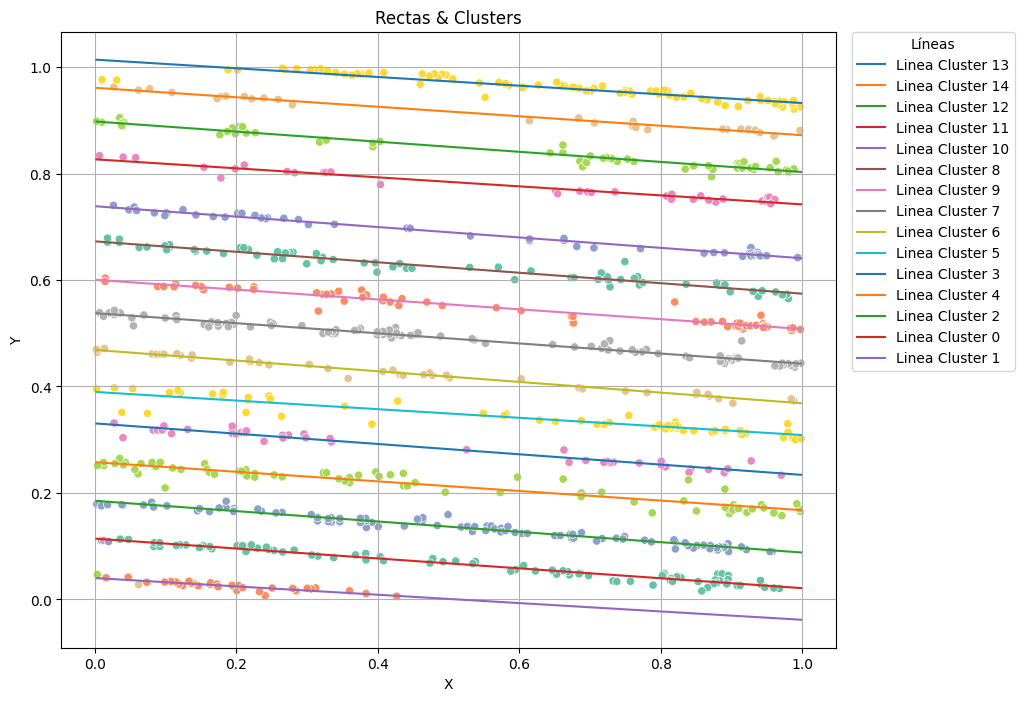

In [ ]:
# Estos objetos se han identificado como clasificaciones erróneas (pertenecen a la línea adyacente)
graficar_lineas_clusters(df_clusters, df_lines)

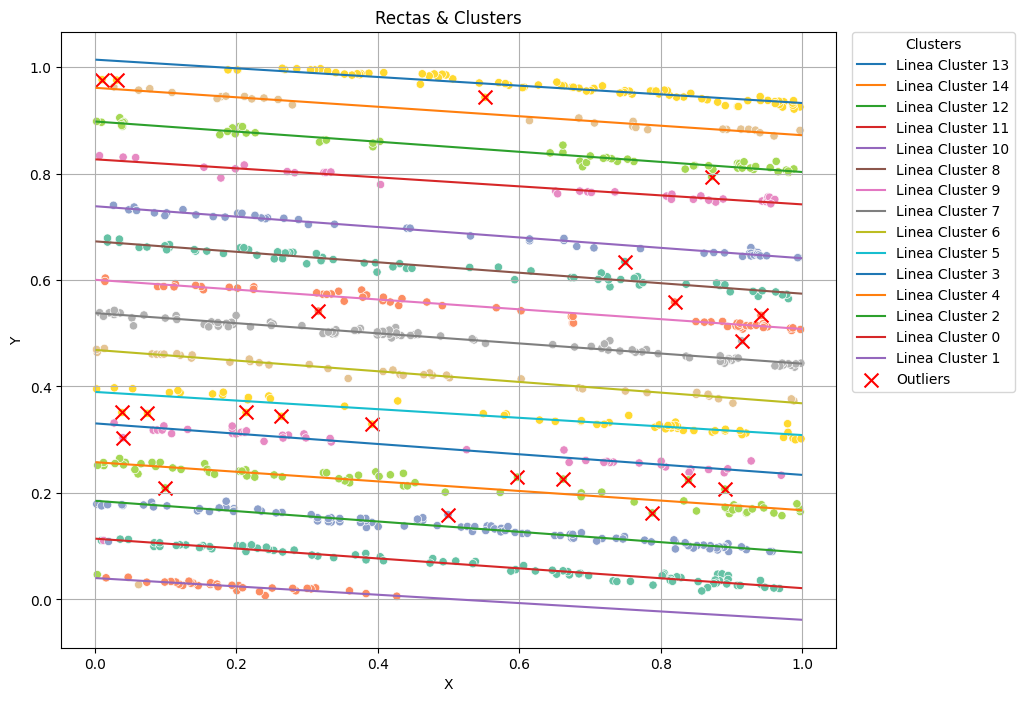

In [ ]:
# Continuan el proceso como outliers los siguientes puntos
graficar_outliers(df_clusters, df_lines, df_outliers)

2. Se asigna el valor `cluster = None` a los outliers, ya que no pertenecen a ninguna línea de cultivo.

In [ ]:
verdaderos_positivos

class_id         x         y  x_rotado  y_rotado  cluster_original  \
index                                                                       
785           0  0.030885  0.975603 -0.032929  0.975536                13   
838           0  0.551535  0.943257  0.488722  0.977279                13   
783           0  0.010234  0.976425 -0.053589  0.975007                13   
755           0  0.871893  0.794134  0.818140  0.849408                12   
622           0  0.749269  0.634594  0.706202  0.682197                 8   
...         ...       ...       ...       ...       ...               ...   
287           0  0.788012  0.162555  0.775706  0.213697                 4   
284           0  0.662098  0.226151  0.645906  0.268931                 4   
225           0  0.099415  0.209430  0.085518  0.215478                 4   
309           0  0.890716  0.207237  0.875272  0.264995                 4   
280           0  0.499269  0.159265  0.487795  0.191548                 2   

       outlier  distancia  desviacion_estandar  id_linea         b  cluster  
index                                                                        
785       True   0.035779             0.006377         1  1.014019       14  
838       True   0.025708             0.006377         1  1.014019       14  
783       True   0.036638             0.006377         1  1.014019       14  
755       True   0.020828             0.004849         3  0.897821       11  
622       True   0.035430             0.005189         4  0.672666       10  
...        ...        ...                  ...       ...       ...      ...  
287       True   0.024087             0.008360        12  0.257820        2  
284       True   0.027941             0.008360        10  0.257820        3  
225       True   0.039263             0.008360        12  0.257820        2  
309       True   0.029641             0.008360        10  0.257820        3  
280       True   0.022400             0.003662        11  0.185302        4  

[22 rows x 12 columns]

In [ ]:
df_clusters.loc[df_clusters.index.isin(verdaderos_positivos.index), 'cluster'] = None

In [ ]:
df_clusters['cluster'].isna().sum()

np.int64(22)

# Conteo final (Output del modelo)

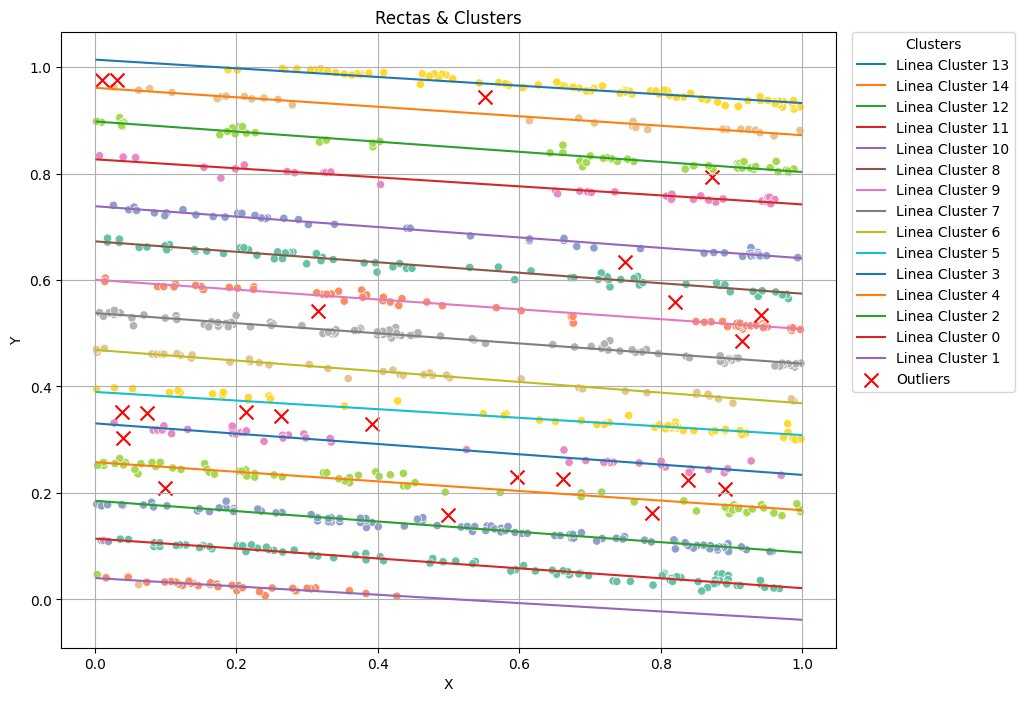

In [ ]:
# Continuan el proceso como outliers los siguientes puntos
graficar_outliers(df_clusters, df_lines, df_outliers)

In [ ]:
df_clusters = df_clusters.dropna()
df_plants = df_labels.loc[df_labels['id_linea'].isin(df_clusters['id_linea'])]
n_plants = len(df_plants)
print(f"Se han detectado un total de {n_plants} plantas.")
df_plants

## Recálculo de desviación estándar sin outliers _(ajuste fino)_

In [ ]:
df_plants = df_clusters[df_clusters['outlier'] == False]

In [ ]:
# RECÁLCULO DE DESVIACIÓN ESTÁNDAR

for index, row in df_lines.iterrows():
    cluster_id = row['cluster']

    # Calcula la recta
    m = row['m']
    b = row['b']
    recta = (m, b)

    # Calcula la dispersión para cada punto
    df_cluster_indices = df_plants['cluster'] == cluster_id
    desviacion_estandar, distancias = calcular_dispersion_cluster(df_plants.loc[df_cluster_indices], recta)

    # Asigna las métricas al DataFrame
    df_plants.loc[df_cluster_indices, 'distancia'] = distancias
    df_plants.loc[df_cluster_indices, 'desviacion_estandar'] = desviacion_estandar

del df_lines['desviacion_estandar']
df_lines = pd.merge(df_lines,df_plants[['cluster','desviacion_estandar']].drop_duplicates(),how='left')
desviacion_estandar_media = df_lines['desviacion_estandar'].mean()
print(f"Desviación estándar media: {desviacion_estandar_media}\n")

Desviación estándar media: 0.0034710924778097825



In [ ]:
df_lines

cluster         m         b  desviacion_estandar
0         0 -0.093063  0.114202             0.003806
1         1 -0.078435  0.040148             0.002808
2         2 -0.097226  0.185302             0.003170
3         3 -0.096788  0.330702             0.003479
4         4 -0.090202  0.257820             0.004523
5         5 -0.081035  0.389774             0.004174
6         6 -0.100364  0.468757             0.003028
7         7 -0.095039  0.537910             0.003587
8         8 -0.098326  0.672666             0.003705
9         9 -0.092500  0.600452             0.003842
10       10 -0.097792  0.738651             0.002643
11       11 -0.084677  0.826755             0.003205
12       12 -0.094926  0.897821             0.004051
13       13 -0.081535  1.014019             0.003616
14       14 -0.089094  0.961121             0.002432

---
# Visualziación de resultados

In [ ]:
H, W, _ = im.shape

In [ ]:
H, W

(3648, 5472)

# Visualización de etiquetas

## Procesamiento del DataFrame

### Absolute values

In [ ]:
df_plants

class_id  x_center  y_center     width    height
0           0  0.083516  0.099507  0.014254  0.012061
1           0  0.084064  0.106360  0.013158  0.006579
2           0  0.009320  0.110746  0.009503  0.010417
3           0  0.012427  0.110746  0.007675  0.012061
4           0  0.019371  0.108827  0.013523  0.014803
..        ...       ...       ...       ...       ...
916         0  0.960161  0.870614  0.009137  0.008772
917         0  0.000000  0.000000  0.000000  0.000000
918         0  1.000000  0.000000  0.000000  0.000000
919         0  0.000000  1.000000  0.000000  0.000000
920         0  1.000000  1.000000  0.000000  0.000000

[921 rows x 5 columns]

In [ ]:
# Se transforma el formato de relativo a absoluto
df_labels_abs = label_transform(df_plants, 'absolute', im_height=H, im_width=W)
df_labels_abs

class_id  x_center  y_center  width  height
0           0       457       363     78      44
1           0       460       388     72      24
2           0        51       404     52      38
3           0        68       404     42      44
4           0       106       397     74      54
..        ...       ...       ...    ...     ...
916         0      5254      3176     50      32
917         0         0         0      0       0
918         0      5472         0      0       0
919         0         0      3648      0       0
920         0      5472      3648      0       0

[921 rows x 5 columns]

### Bounding Boxes calculation

In [ ]:
df_BBoxes = lbl_to_bb(df_labels_abs)
df_BBoxes

class_id    x0    x1    y0    y1
0           0   418   496   341   385
1           0   424   496   376   400
2           0    25    77   385   423
3           0    47    89   382   426
4           0    69   143   370   424
..        ...   ...   ...   ...   ...
916         0  5229  5279  3160  3192
917         0     0     0     0     0
918         0  5472  5472     0     0
919         0     0     0  3648  3648
920         0  5472  5472  3648  3648

[921 rows x 5 columns]

## Visualización puntos

In [ ]:
df_labels_abs

class_id  x_center  y_center  width  height
0           0       457       363     78      44
1           0       460       388     72      24
2           0        51       404     52      38
3           0        68       404     42      44
4           0       106       397     74      54
..        ...       ...       ...    ...     ...
916         0      5254      3176     50      32
917         0         0         0      0       0
918         0      5472         0      0       0
919         0         0      3648      0       0
920         0      5472      3648      0       0

[921 rows x 5 columns]

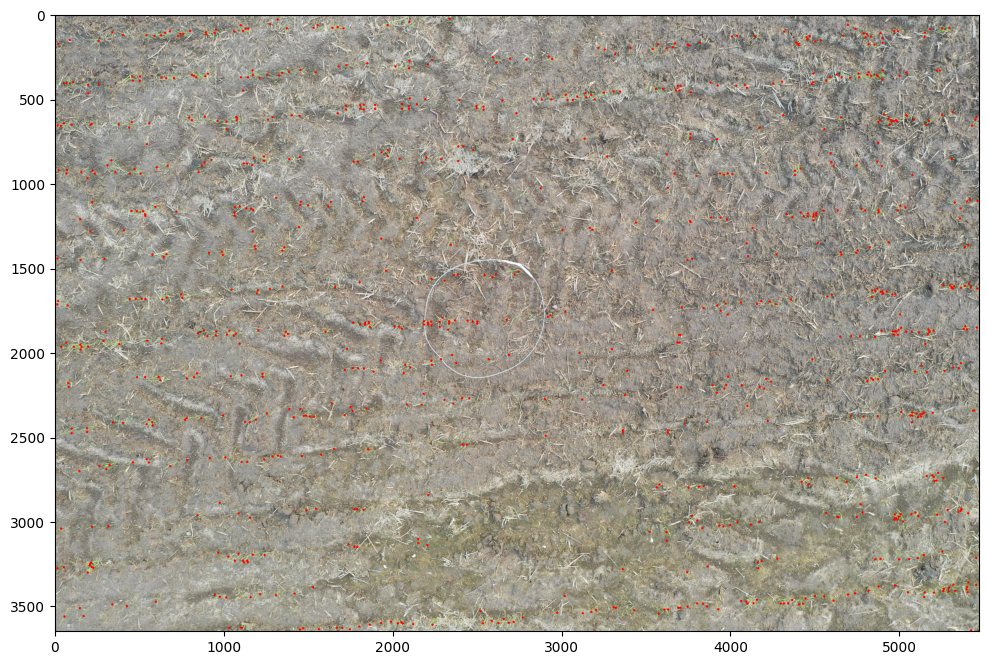

In [ ]:
draw_points(im, df_labels_abs)

## Visualización Bounding Boxes

In [ ]:
df_BBoxes

class_id    x0    x1    y0    y1
0           0   418   496   341   385
1           0   424   496   376   400
2           0    25    77   385   423
3           0    47    89   382   426
4           0    69   143   370   424
..        ...   ...   ...   ...   ...
916         0  5229  5279  3160  3192
917         0     0     0     0     0
918         0  5472  5472     0     0
919         0     0     0  3648  3648
920         0  5472  5472  3648  3648

[921 rows x 5 columns]

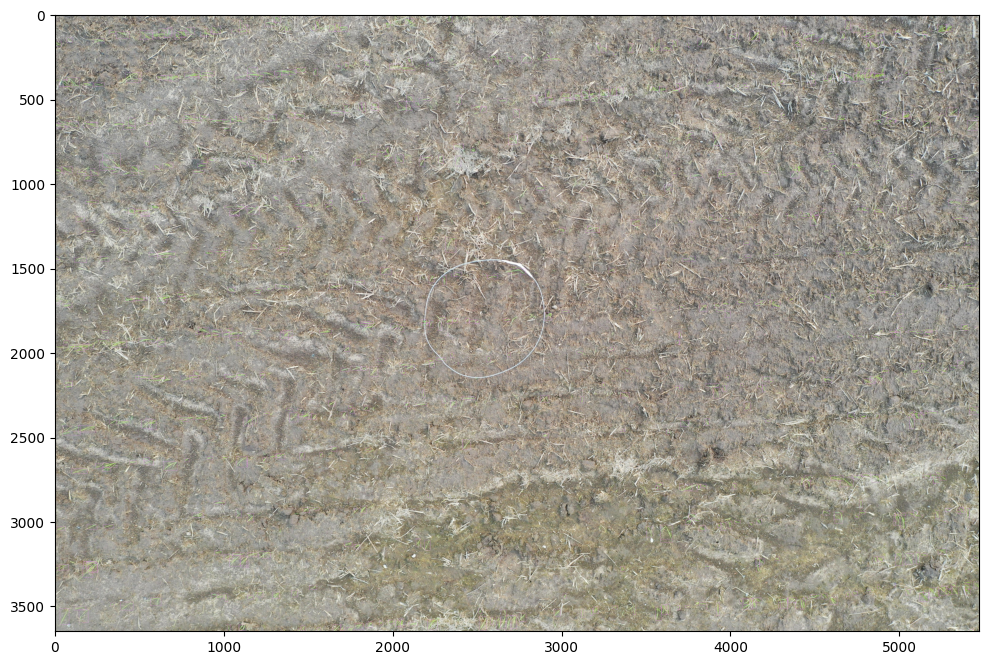

In [ ]:
# Se deben enviar copias del array y dataframe por ser objetos mutables
draw_bb(im,df_BBoxes)

# Visualización de líneas

In [ ]:
df_lines

index  cluster         m         b
0       0       13 -0.079986  1.012866
1       1       14 -0.089094  0.961121
2       2       12 -0.094926  0.897821
3       3       11 -0.084677  0.826755
4       4       10 -0.097792  0.738651
5       5        8 -0.098326  0.672666
6       6        9 -0.092336  0.600893
7       7        7 -0.095039  0.537910
8       8        6 -0.103550  0.469282
9       9        5 -0.081035  0.389774
10     10        3 -0.096788  0.330702
11     11        4 -0.090202  0.257820
12     12        2 -0.097226  0.185302
13     13        0 -0.093063  0.114202
14     14        1 -0.078435  0.040148

Línea 0: m = -0.07998555234059858, b = 1.012866405760486
  y_start = 1, y_end = 0
Línea 1: m = -0.08909378553187633, b = 0.961120795197261
  y_start = 0, y_end = 0
Línea 2: m = -0.09492636056354242, b = 0.8978213493570358
  y_start = 0, y_end = 0
Línea 3: m = -0.08467674103264944, b = 0.8267548353328902
  y_start = 0, y_end = 0
Línea 4: m = -0.09779202788665572, b = 0.7386508149378923
  y_start = 0, y_end = 0
Línea 5: m = -0.09832626544306697, b = 0.6726661495938615
  y_start = 0, y_end = 0
Línea 6: m = -0.09233580422496368, b = 0.6008931848497088
  y_start = 0, y_end = 0
Línea 7: m = -0.09503889897686593, b = 0.5379099456776099
  y_start = 0, y_end = 0
Línea 8: m = -0.10355038817605247, b = 0.46928160169029504
  y_start = 0, y_end = 0
Línea 9: m = -0.08103514519474107, b = 0.38977375403545683
  y_start = 0, y_end = 0
Línea 10: m = -0.09678786875465137, b = 0.3307019062162084
  y_start = 0, y_end = 0
Línea 11: m = -0.09020175017858786, b = 0.2578195102631105
  y_start = 0, y_end = 0
Lí

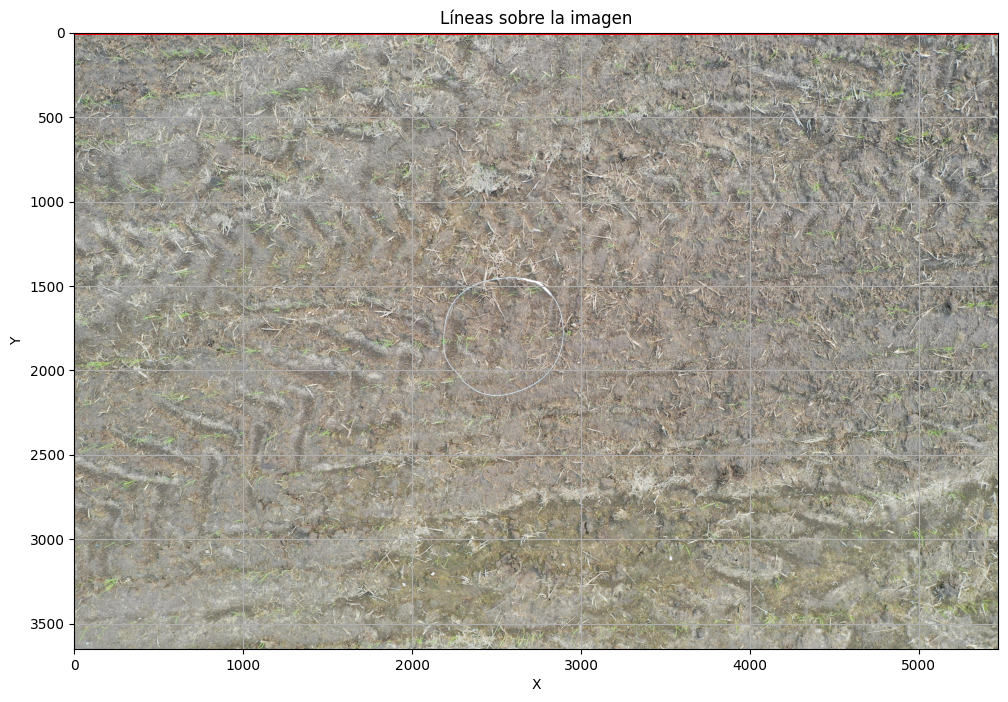

<Figure size 640x480 with 0 Axes>

In [ ]:

fig = plt.figure(figsize=(12, 8))
ax = plt.subplot()

# Mostrar la imagen original
ax.imshow(im, cmap='gray')
ax.set_ylim((im.shape[0], 0))
ax.set_xlim((0, im.shape[1]))
ax.set_title('Líneas sobre la imagen')

# Graficar las líneas de df_lines ajustadas a las dimensiones de la imagen
for index, row in df_lines.iterrows():
    m = row['m']
    b = row['b']

    # Imprimir valores de m y b para depuración
    print(f"Línea {index}: m = {m}, b = {b}")

    # Calcular puntos de inicio y fin para los bordes de la imagen
    x_start = 0
    y_start = int(m * x_start + b)
    x_end = im.shape[1] - 1  # Ancho de la imagen menos 1
    y_end = int(m * x_end + b)

    # Ajustar puntos para que estén dentro de los límites de la imagen
    y_start = max(0, min(y_start, im.shape[0] - 1))
    y_end = max(0, min(y_end, im.shape[0] - 1))

    # Imprimir valores de y_start y y_end para depuración
    print(f"  y_start = {y_start}, y_end = {y_end}")

    # Graficar la línea con grosor aumentado y color rojo
    ax.plot([x_start, x_end], [y_start, y_end], color='red', linewidth=2)

# Configurar el gráfico
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.grid(True)
plt.show()

plt.tight_layout()
plt.show()